# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

from quantum_electron.electron_counter import FullModel
from quantum_electron.schrodinger_solver import find_minimum_location, make_potential
from quantum_electron.utils import r2xy, xy2r
from zeroheliumkit.fem import FieldAnalyzer
from zeroheliumkit import Structure, Rectangle,GeomCollection
from zeroheliumkit.src.importing import Reader_GDS
from zeroheliumkit.src.plotting import default_ax
from zeroheliumkit.src.settings import *
from zeroheliumkit.helpers.constants import *

c:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


# Device and FEM Results

reduced.gds // Layers in cell 'TOP': {28, 22}


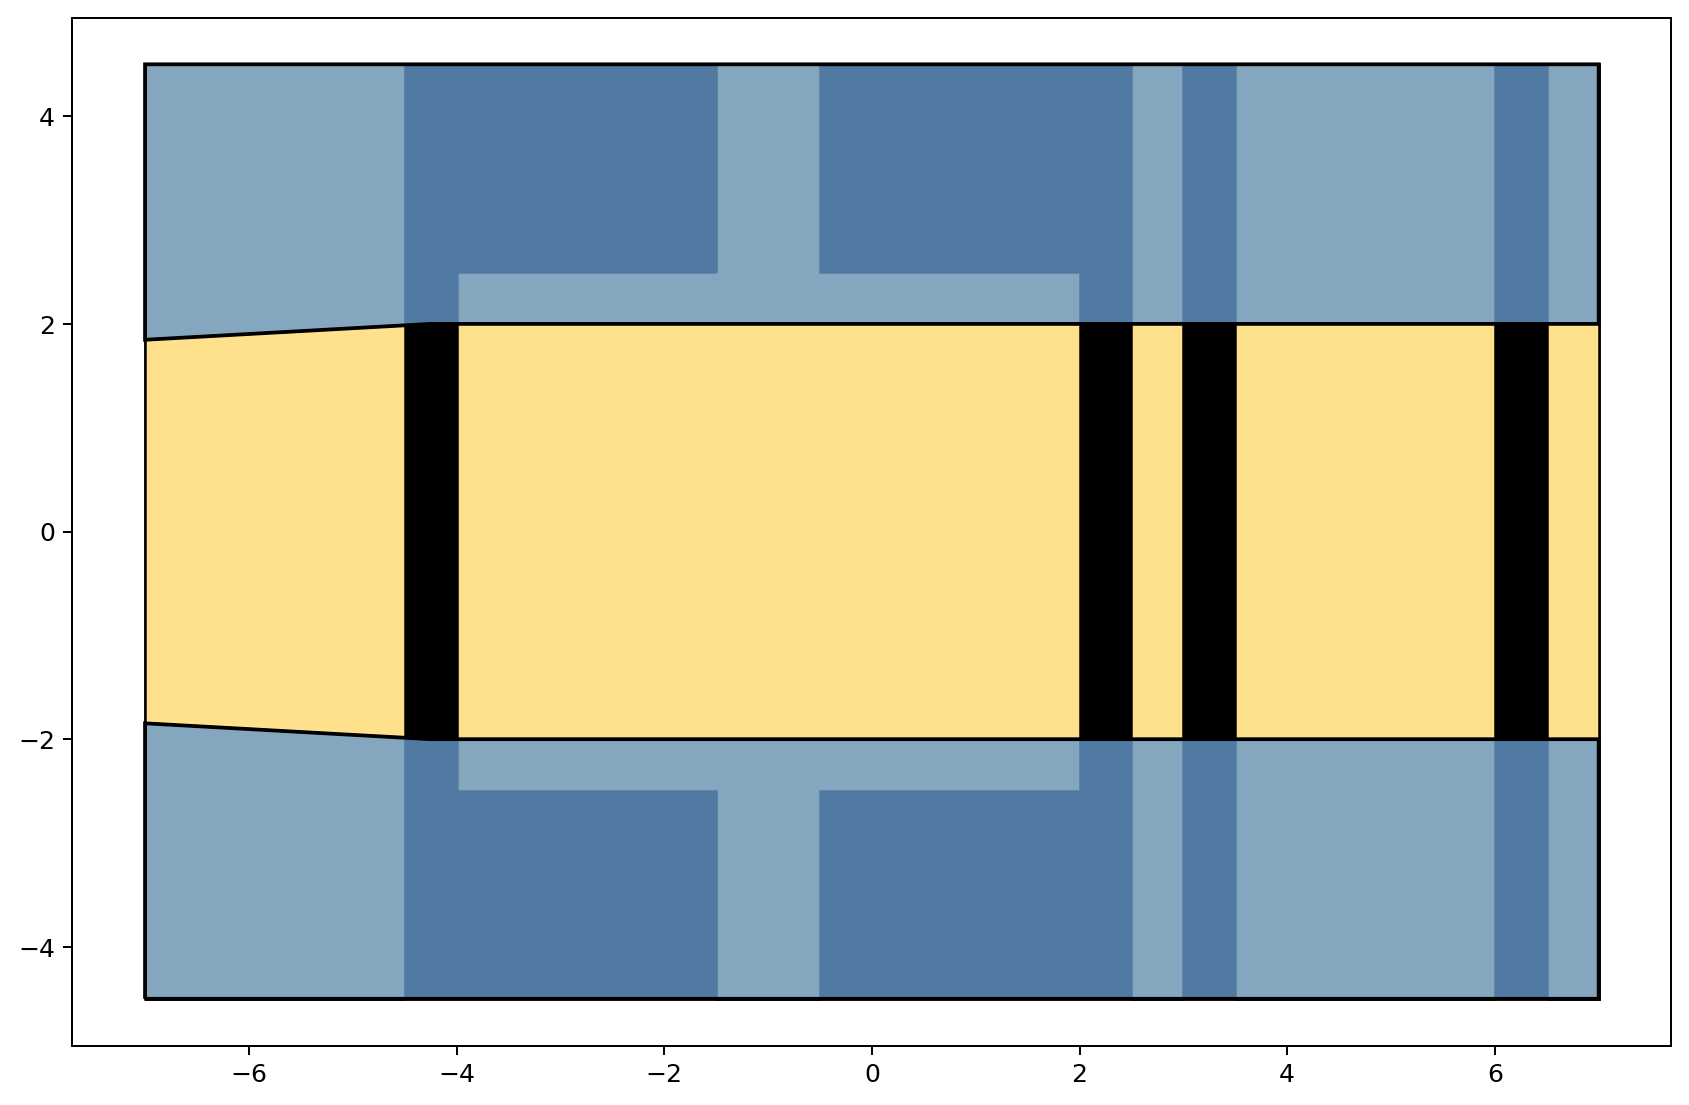

In [2]:
plot_config = {'wafer':BLACK,'bottom':YELLOW2,'top':(BLUE,0.8)}
# Read File
file = Reader_GDS('reduced.gds')
file.import2zhk("TOP")
device = GeomCollection(file.geometries)
#Add a "wafer" Layer
device.add_layer('wafer', Rectangle(14,9,(0,0)))
# Rename Layers
# device.rename_layer('L0','extra')
device.rename_layer('L22','bottom')
device.rename_layer('L28','top')
device.layers
#Show Device
device.quickplot(plot_config)

ph = FieldAnalyzer(("twiddleSense_phi_xy.txt", 'phi', '2Dmap'))
p = ph.phi

# Definitions 

In [3]:
hbar = 1.05457182e-34       # [J*s]             plank's constant          
epsilon_0 = 8.854e-12       # [F/m]             vacuum permittivity
mu_0 = 1.25663706e-6        # [N/A^2]   vacuum permeability
epsilon_He = 1.057          # [1]               dielectric constant of helium
qe = 1.602e-19              # [Coulombs]        electron charge
me = 9.1093837e-31          # [kg]              electron mass
g = 9.81                    # [m/s^2]           gravity constant
alpha = 3.58e-4             # [N/p]             surface tension
rho = 146                   # [kg/m^3]          helium density
kb = 1.3806e-23             # [J/K]             boltzman constant
speedoflight = 299792458.0  # [m/s]             speed of light

GHz = 1e9
MHz = 1e6
kHz = 1e3

cm = 1e-2
mm = 1e-3
um = 1e-6
nm = 1e-9

options = {"include_screening" : False, # Include screening of electron-electron interactions due to thin film.
           "screening_length" : 0.6e-6, # Typically helium thickness.
           "potential_smoothing" : 1e-1, # Numerical smoothing of the splines (gets rid of some noise, can introduce artifacts)
           "remove_unbound_electrons" : True, # Removes electrons if they shot outside the solution box.
           "remove_bounds" : (-1.0e-6, 1.0e-6), # Sets which electrons should be removed if above is True.
           "trap_annealing_steps" : [0.5] * 0, # List of annealing temperatures, length determines the number of steps
           "max_x_displacement" : 0.1e-6, # Maximum x-displacement of solved electron positions during annealing.
           "max_y_displacement" : 0.1e-6} # Maximum y-displacement of solved electron positions during annealing.

# Coupling Constants

In [4]:
ph.phi.keys()

dict_keys(['Door1', 'Door2', 'Guard', 'Sense', 'Top', 'Twiddle', 'xlist', 'ylist'])

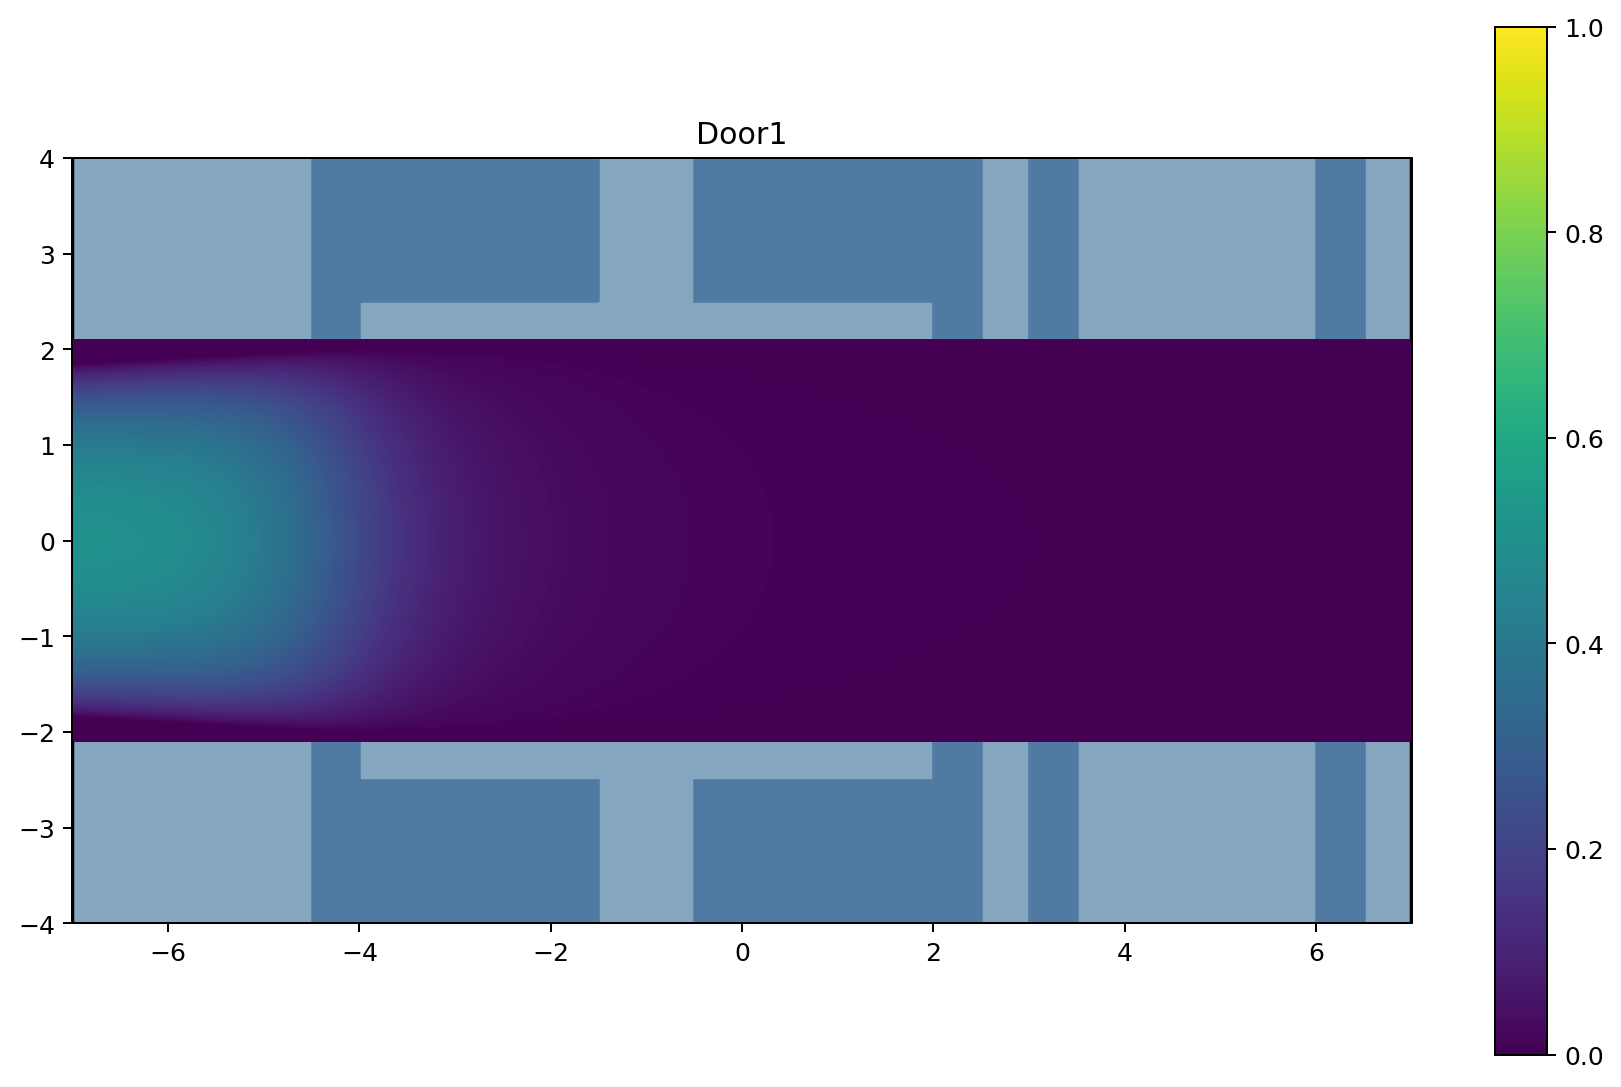

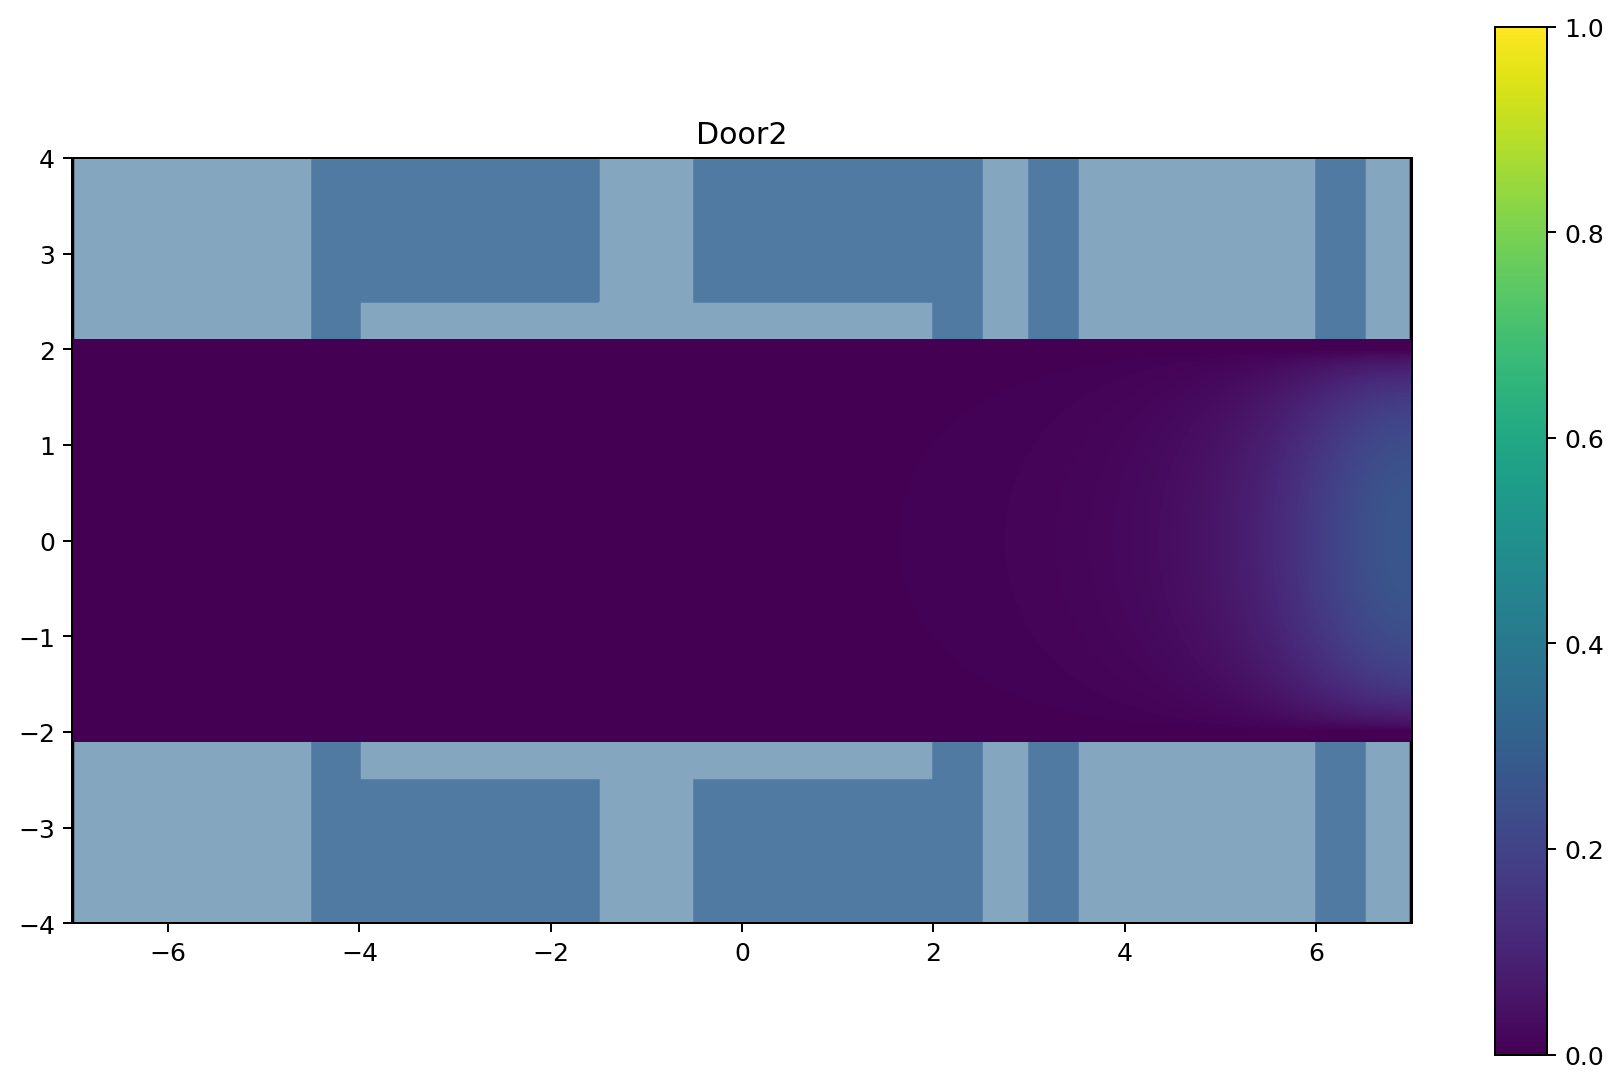

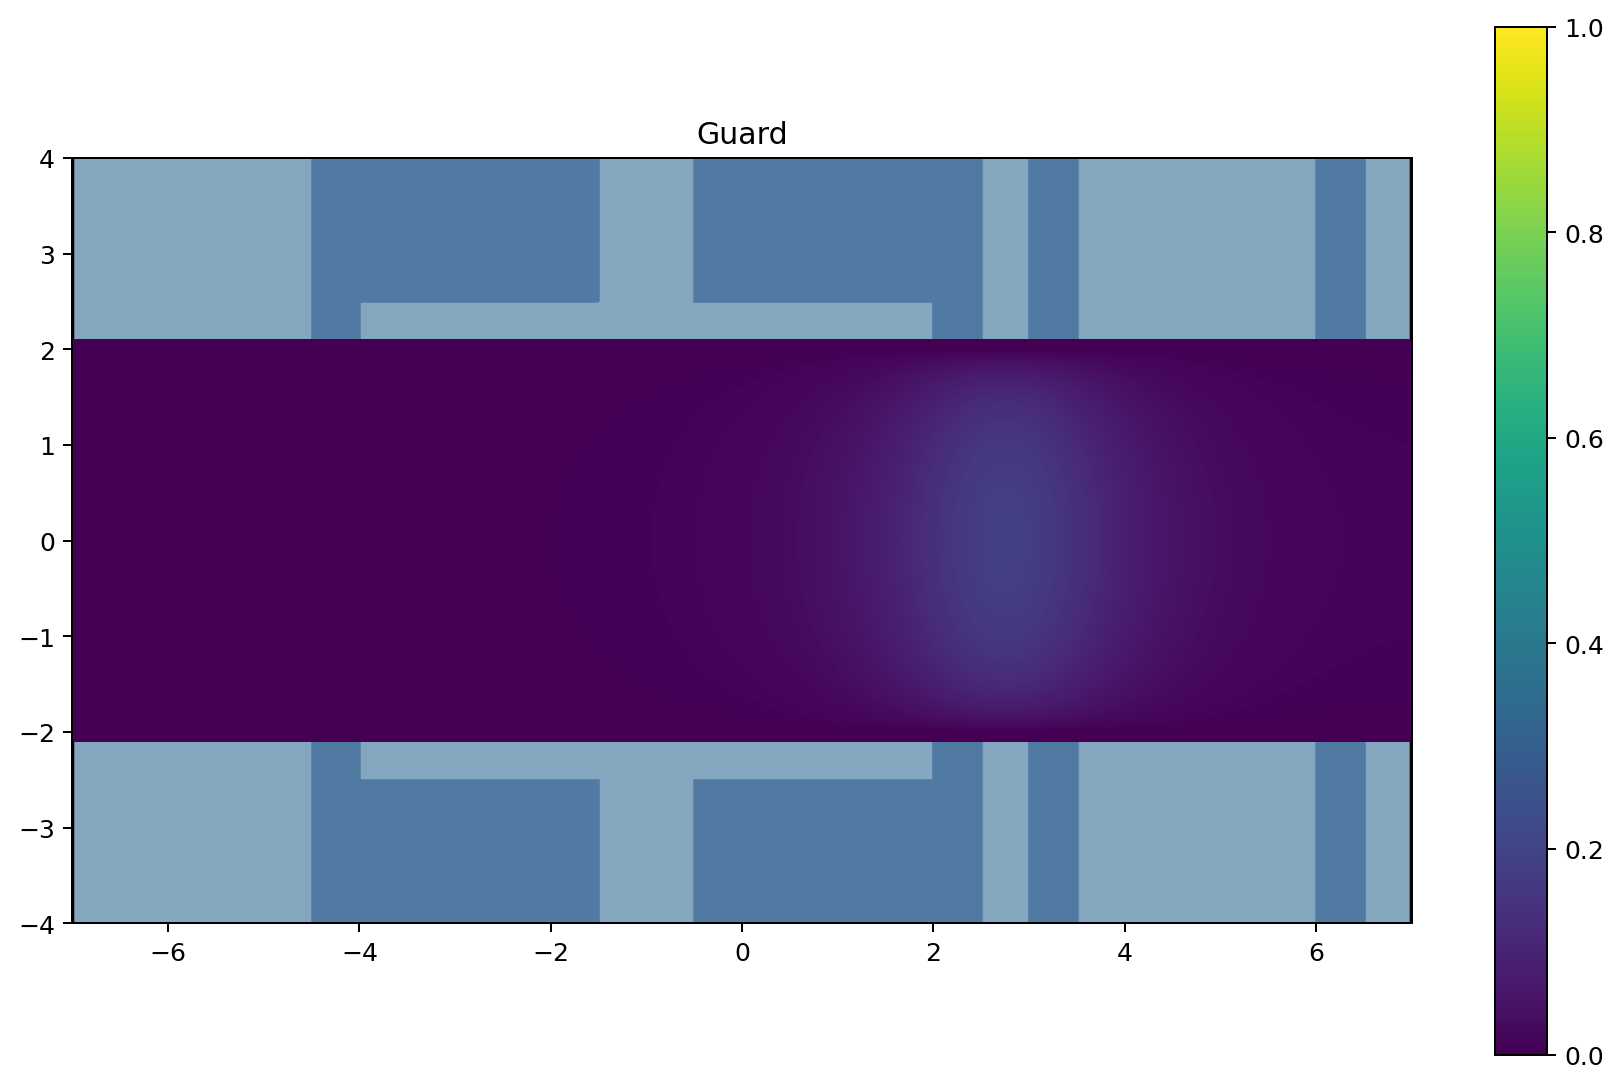

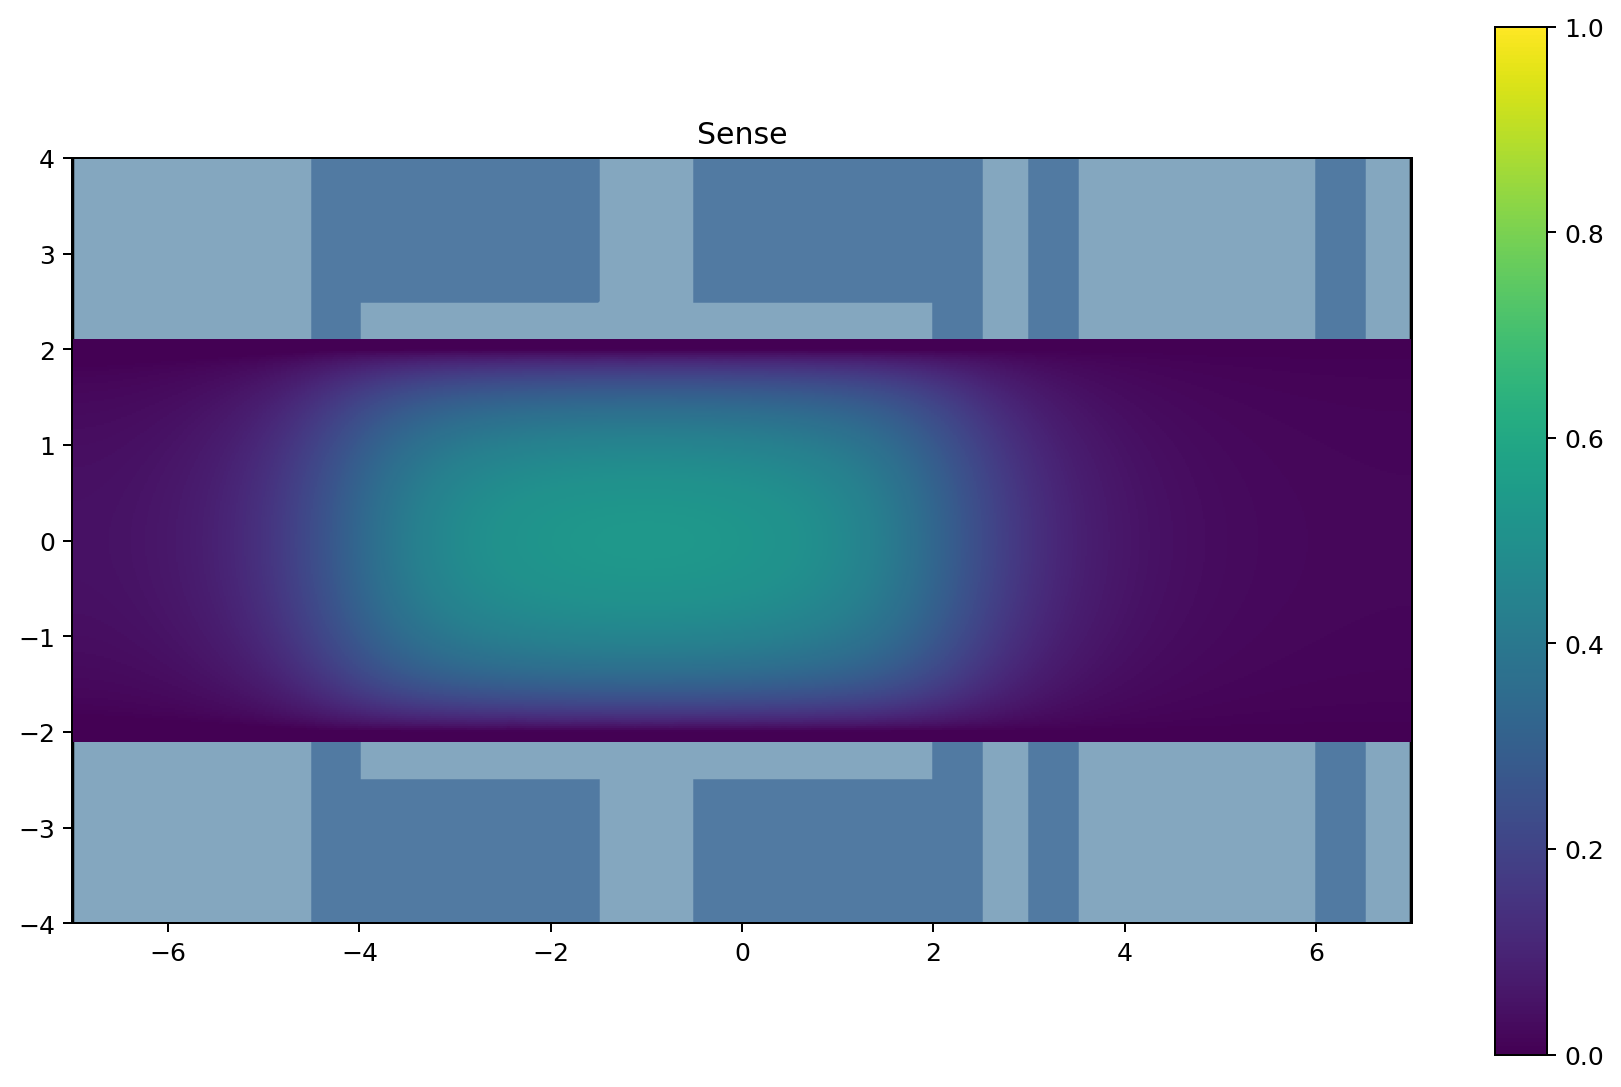

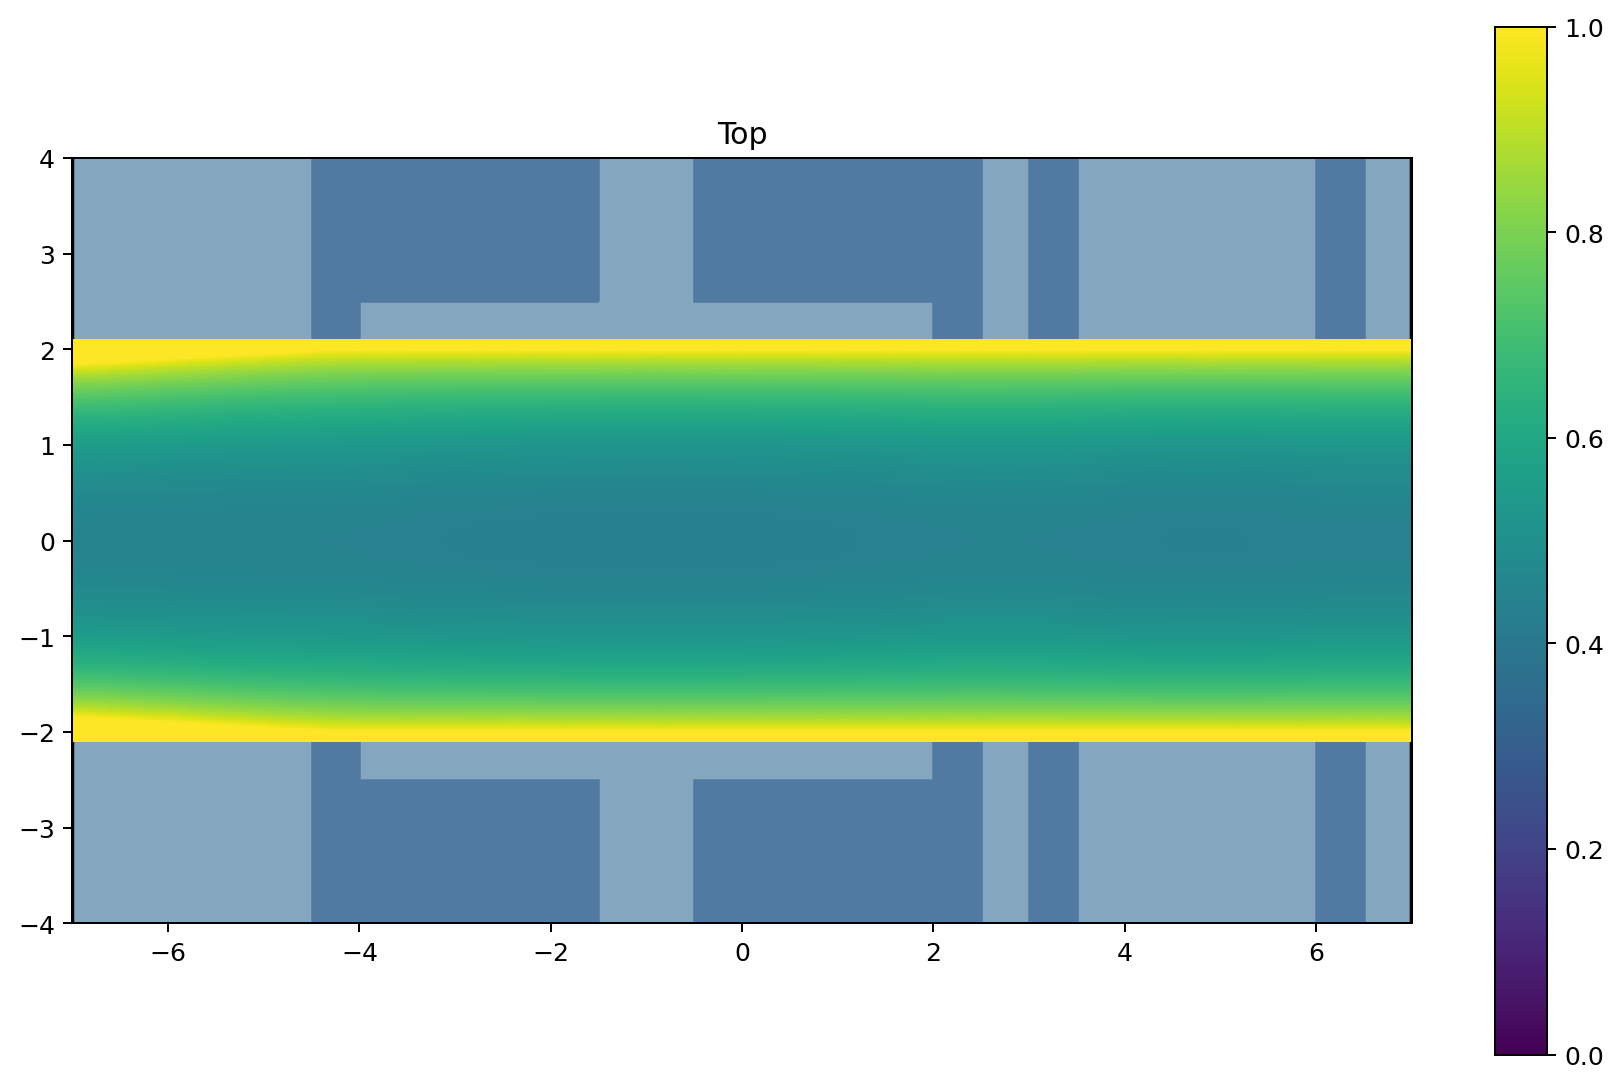

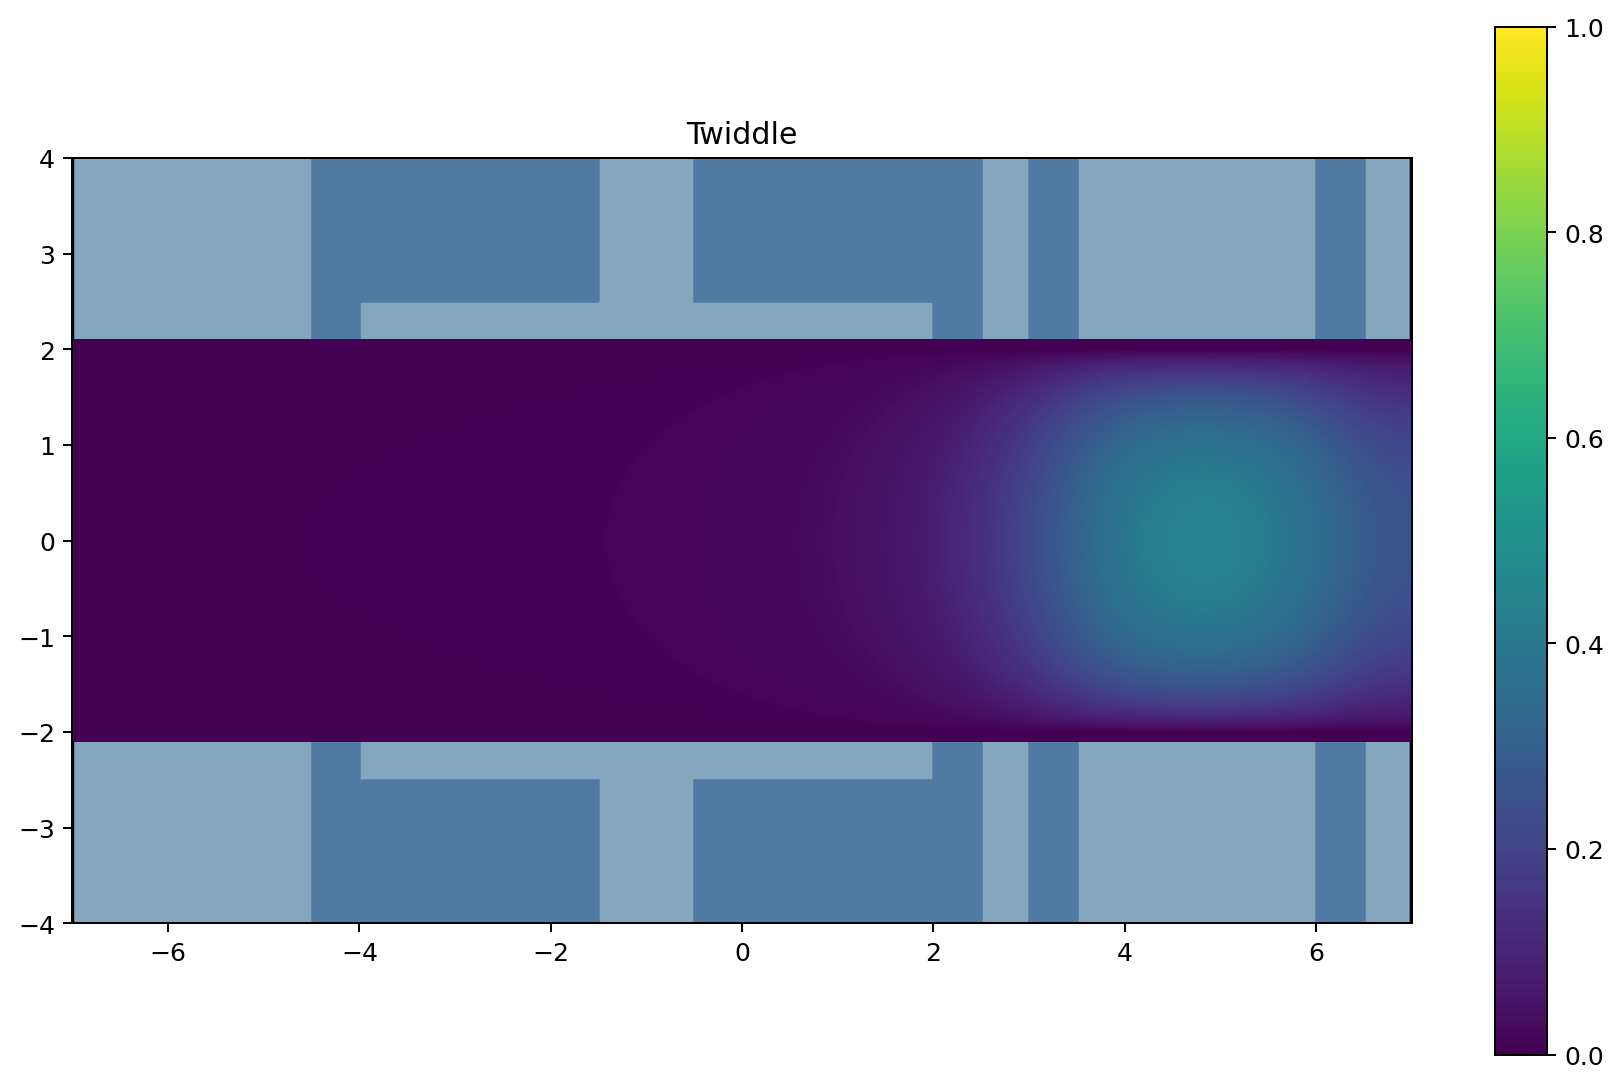

In [5]:
# By setting the voltage of each gate to 1, we can plot the coupling constants
voltages = {
    'Door1':0,
    'Door2':0,
    # 'Extra':0,
    'Guard':0,
    'Sense':0,
    'Top':0,
    'Twiddle':0,
}
for k,v in voltages.items():
    voltages[k] = 1
    x,y,z = ph.potential(ph.phi,voltages)

    x,y,z = ph.potential(ph.phi,voltages)
    device.quickplot(plot_config)
    plt.pcolormesh(x,y,z.T,alpha = 1)
    plt.clim(0,1)
    plt.colorbar()
    plt.xlim(-7,7)
    plt.ylim(-4,4)
    plt.title(k)
    plt.show()

    voltages[k] = 0

# DC Voltage Config

### Look at a random voltage config

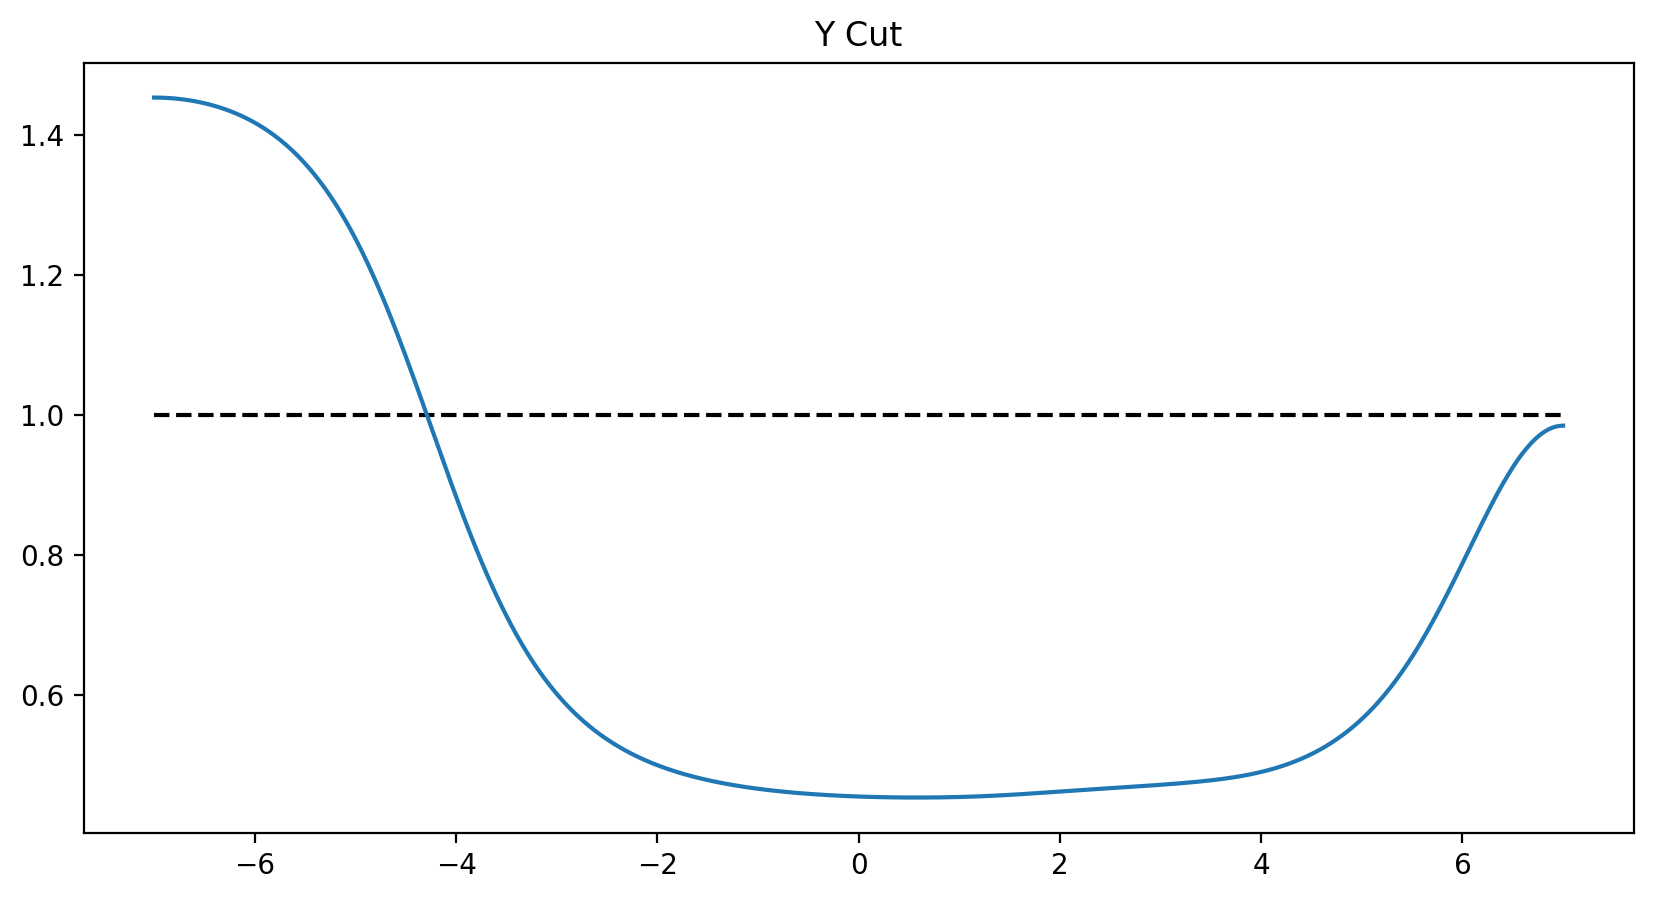

In [6]:
voltages = {
    'Door1':-2,
    'Door2':-2,
    # 'Extra':0,
    'Guard':0,
    'Sense':0,
    'Top':-1,
    'Twiddle':0,
}


x,y,z = ph.potential(p,voltages)

# Take a line cut along the middle and add a dashed line at the top ground plane potential
yC = int(len(y)/2)
plt.figure(figsize=(10,5))
plt.title('Y Cut')
plt.hlines(-voltages['Top'],x.min(),x.max(),'k','--')
plt.plot(x,-z[:,yC])



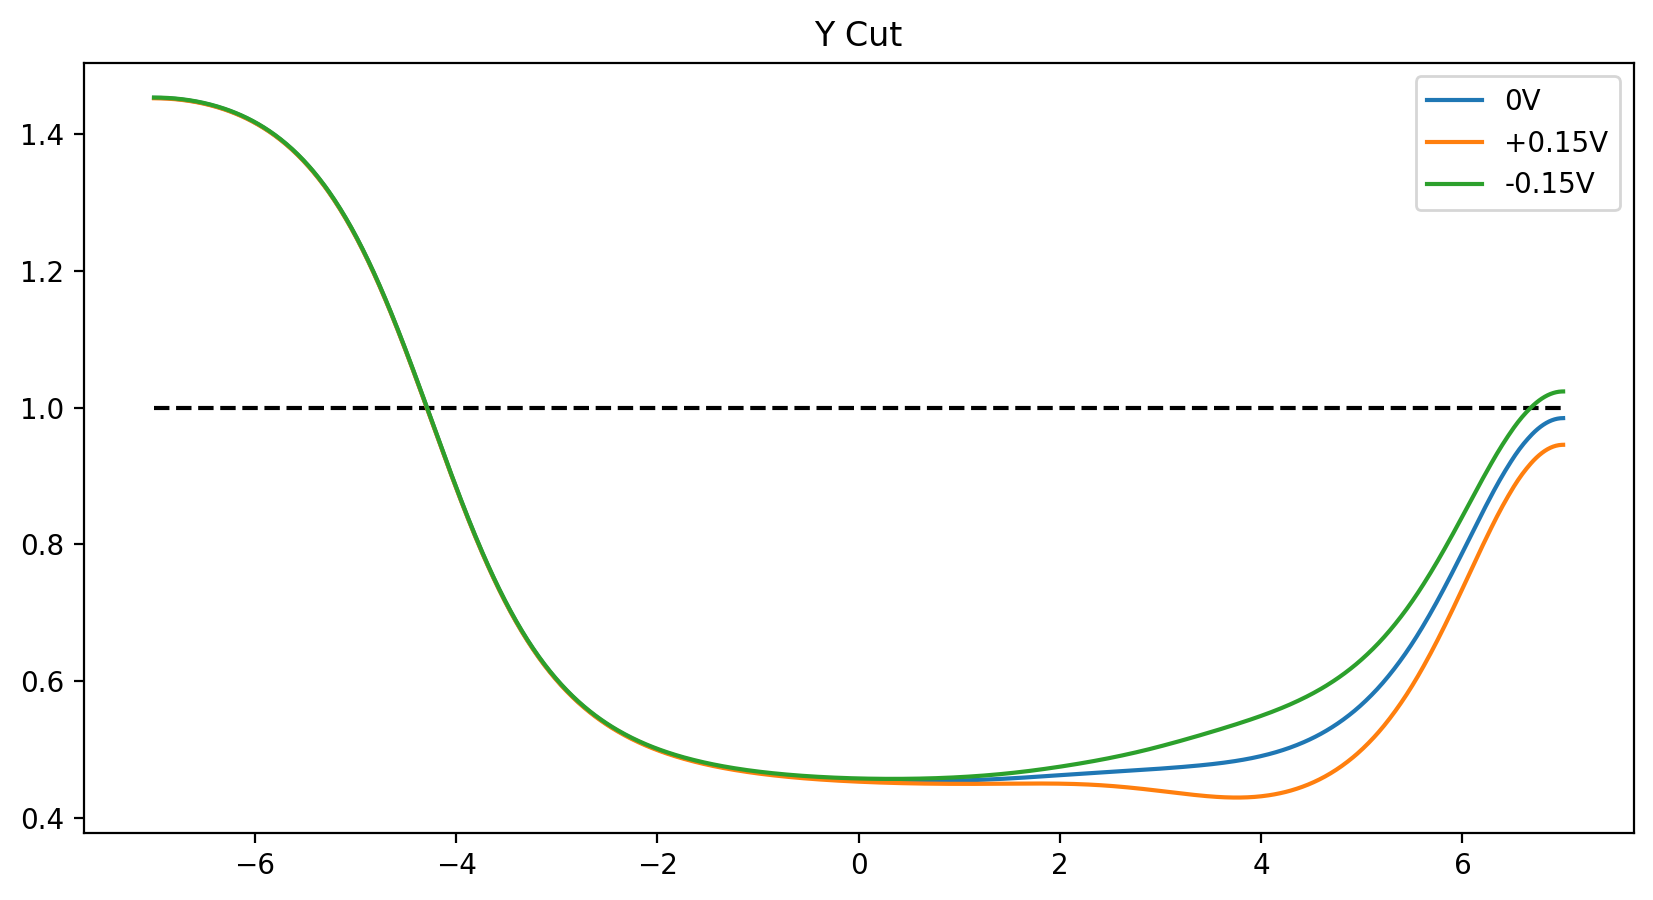

In [7]:
voltages = {
    'Door1':-2,
    'Door2':-2,
    # 'Extra':0,
    'Guard':0,
    'Sense':0,
    'Top':-1,
    'Twiddle':0,
}
x,y,z = ph.potential(p,voltages)
yC = int(len(y)/2)

# Plot some line cuts along the center 
plt.figure(figsize=(10,5))
plt.title('Y Cut')
plt.plot(x,-z[:,yC],label='0V')
plt.hlines(-voltages['Top'],x.min(),x.max(),'k','--')

# Add a line, but with the twiddle at +0.15
voltages['Twiddle'] = .15
x,y,z = ph.potential(p,voltages)
plt.plot(x,-z[:,yC],label='+0.15V')

# Add a line, but with the twiddle at -0.15
voltages['Twiddle'] = -.15
x,y,z = ph.potential(p,voltages)
plt.plot(x,-z[:,yC],label='-0.15V')

plt.legend()
plt.show()


# Electron Counting

## Functions

In [8]:
import numpy as np

def generate_coords_deterministic(N, x0,y0,min_spacing=0):
    coords = []
    if min_spacing == 0:
        a = 0.1
    else:
        a = min_spacing
    r_max = a

    count = 0
    while count < N:
        coords.clear()
        r_max += a * 0.5  
        n_rings = int(r_max / a) + 1
        for i in range(-n_rings, n_rings + 1):
            for j in range(-n_rings, n_rings + 1):
                x = a * (i + 0.5 * j)
                y = a * (np.sqrt(3)/2) * j
                r = np.sqrt(x**2 + y**2)
                if r <= r_max:
                    coords.append((x0 + x, y0 + y))
                    if len(coords) >= N:
                        break
            if len(coords) >= N:
                break
        count = len(coords)

    return np.array(coords[:N])

def get_min_energy_forcemethod(fm,n_electrons: int=10,n_timesteps = 20_000,dt = 1e-13,gamma = -.01,init_coords=None,returnAll = False):
    gamma = gamma * me / dt # This is the damping parameter. 
    if init_coords is None:
        initial_condition = generate_coords_deterministic(int(N),0,0,0.15).flatten()*1e-6
    else:
        initial_condition = init_coords
    r = np.zeros((2 * n_electrons, n_timesteps+2))

    r[:, 0] = initial_condition
    r[:, 1] = initial_condition

    for k in range(2, n_timesteps+2):
        prefactor = 1 / (me / dt ** 2 - gamma / dt)
        F = - qe * fm.grad_total(r[:, k-1])
        r[:, k] = prefactor * (F - r[:, k-1] * (-2 * me / dt ** 2 + gamma / dt) - r[:, k-2] * me / dt ** 2)
    if returnAll:
        electron_positions = r
    else:
        electron_positions = r[:, -1]
    return electron_positions

## Solve Postions

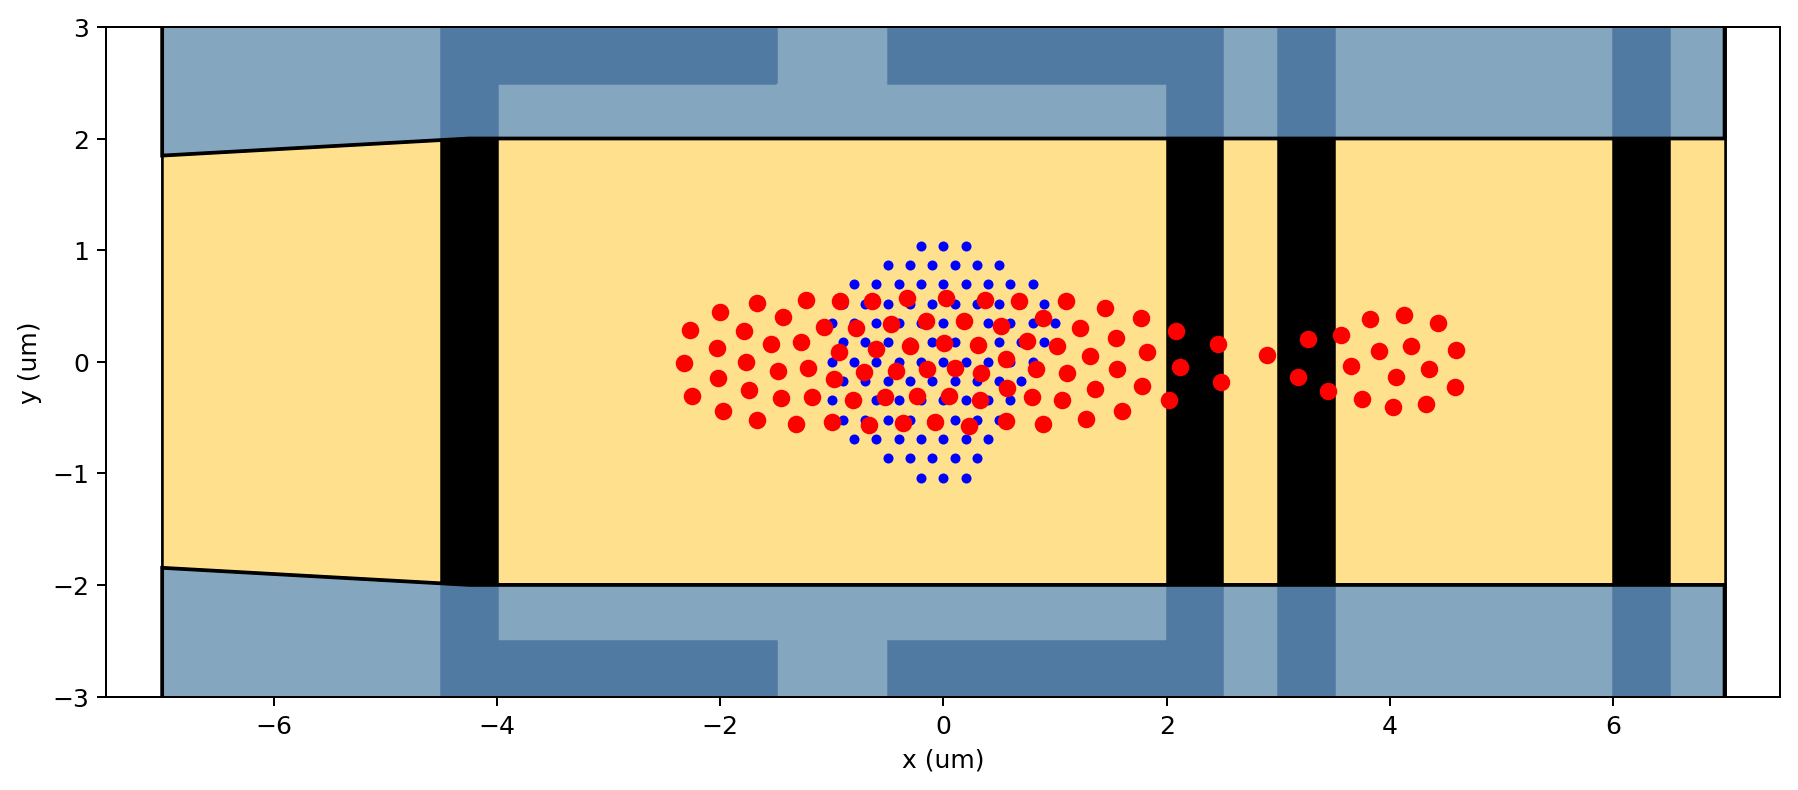

In [9]:
voltages = {
    'Door1':-2,
    'Door2':-2,
    # 'Extra':0,
    'Guard':-.3,
    'Sense':0,
    'Top':-1,
    'Twiddle':0,
}

N = 100
min_spacing = 0.2
x0,y0 = 0,0

x,y,z = ph.potential(p,voltages)
fm = FullModel(ph.phi, voltages, **options)

init_coords = generate_coords_deterministic(int(N),x0,y0,min_spacing).flatten()*1e-6
final_coords = get_min_energy_forcemethod(fm,N,n_timesteps = 2000,init_coords=init_coords)


device.quickplot(plot_config)
plt.xlim(-7.5,7.5)
plt.ylim(-3,3)
for xi,yi in zip(init_coords[0::2],init_coords[1::2]):
    plt.plot(xi*1e6,yi*1e6,'b.')
for xi,yi in zip(final_coords[0::2],final_coords[1::2]):
    plt.plot(xi*1e6,yi*1e6,'ro')
plt.ylabel("y (um)")
plt.xlabel("x (um)")
plt.show()

# Solve Dynamic Postions

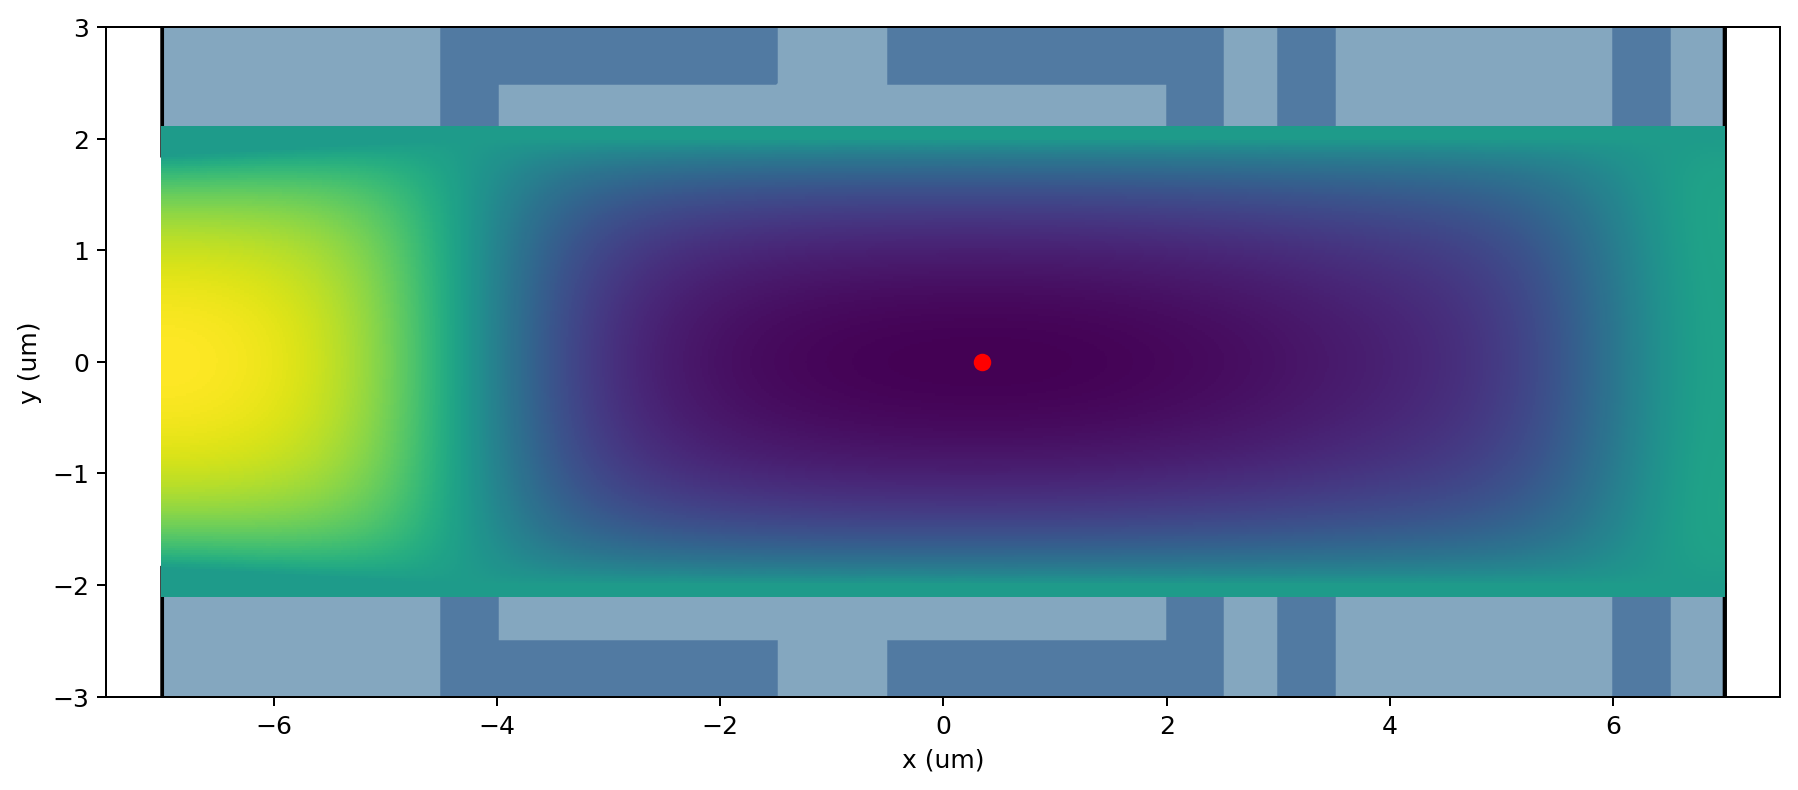

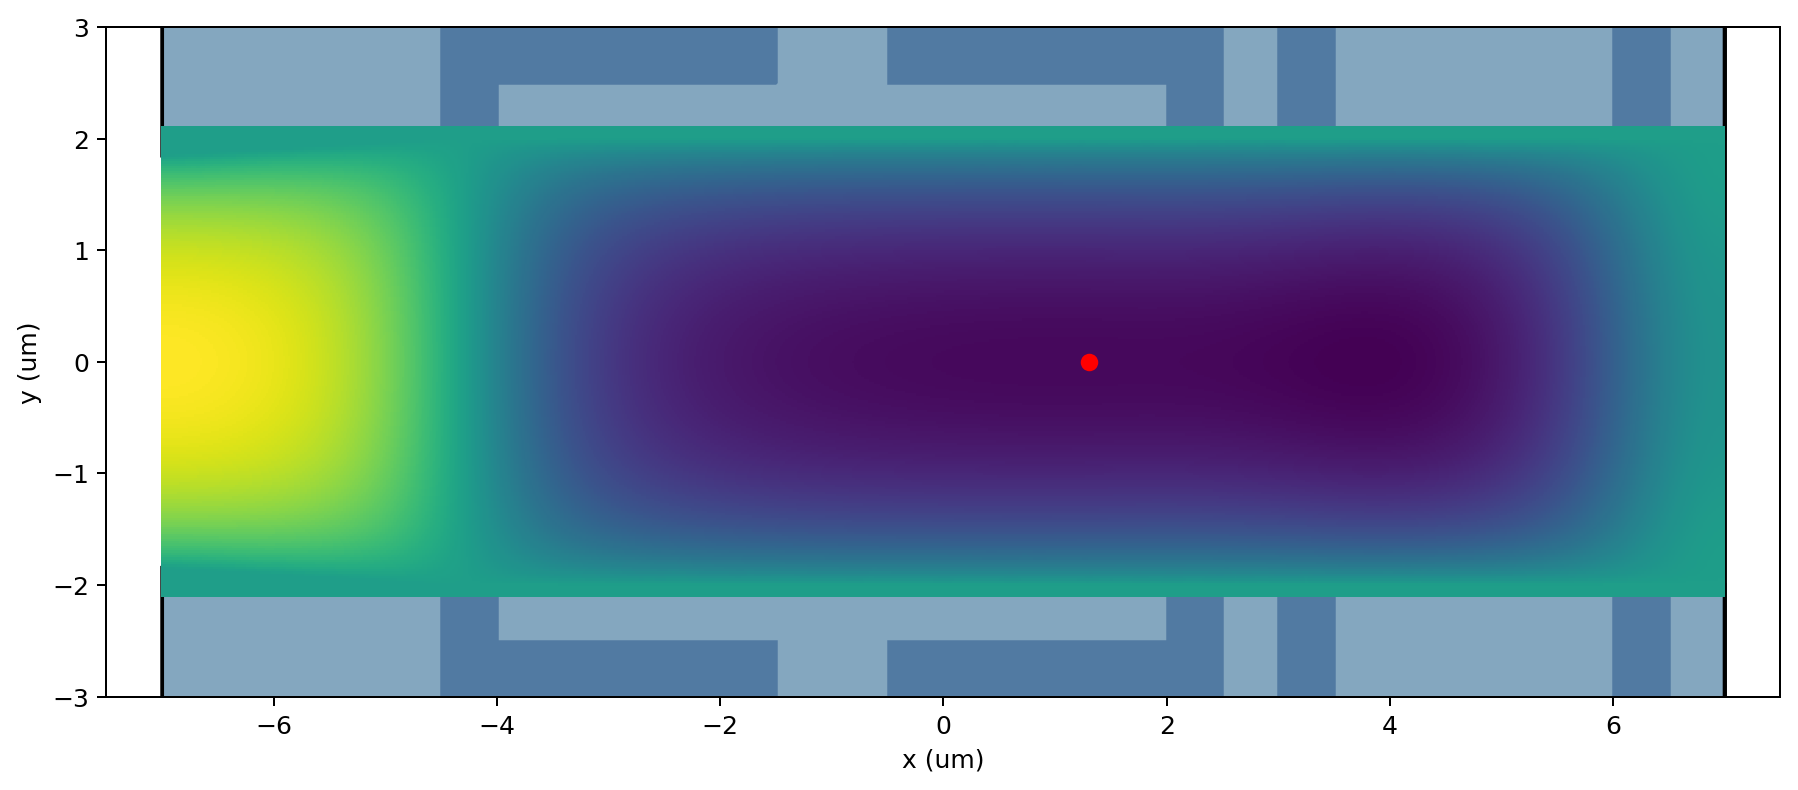

In [10]:
voltages = {
    'Door1':-2,
    'Door2':-2,
    # 'Extra':0,
    'Guard':0,
    'Sense':0,
    'Top':-1,
    'Twiddle':0,
}

N = 1
min_spacing = 0.1
x0,y0 = 0,0
vpp = 0.3

coords = generate_coords_deterministic(int(N),x0,y0,min_spacing).flatten()*1e-6
coords = get_min_energy_forcemethod(fm,N,n_timesteps = 5000,init_coords=coords)

for twiddle in [-vpp/2,vpp/2]:
    voltages['Twiddle'] = twiddle
    x,y,z = ph.potential(p,voltages)
    fm = FullModel(ph.phi, voltages, **options)
    coords = get_min_energy_forcemethod(fm,N,n_timesteps = 5000,init_coords=coords)
    
    device.quickplot(plot_config)
    plt.pcolormesh(x,y,-z.T)
    plt.xlim(-7.5,7.5)
    plt.ylim(-3,3)
    for xi,yi in zip(coords[0::2],coords[1::2]):
        plt.plot(xi*1e6,yi*1e6,'ro')
    plt.ylabel("y (um)")
    plt.xlabel("x (um)")
    plt.show()

## Maybe for a range of guard voltages

0


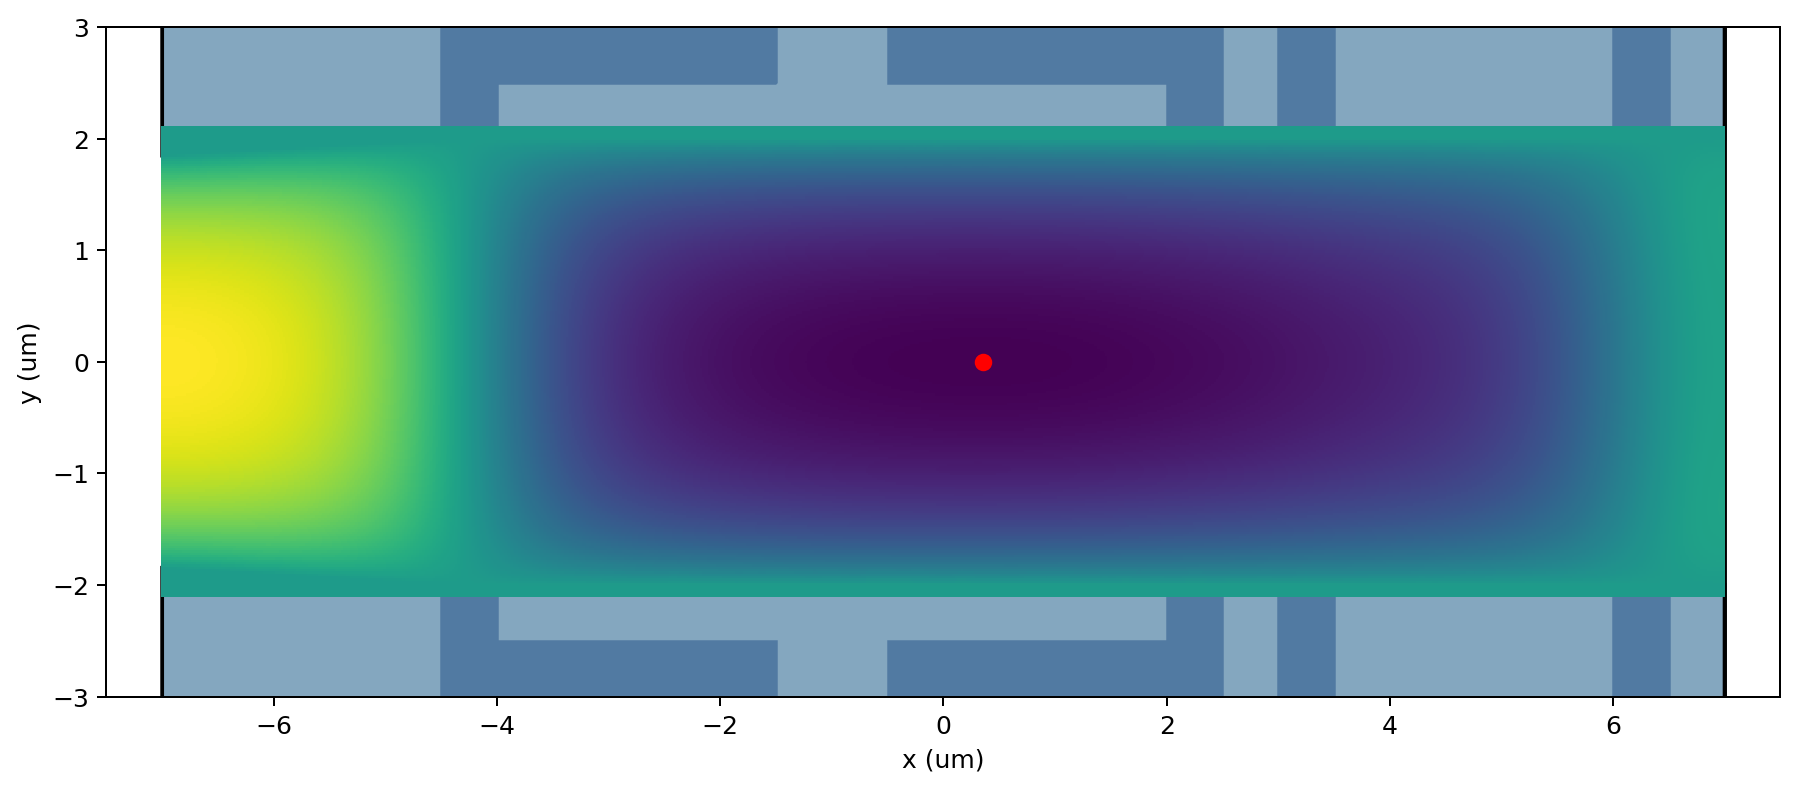

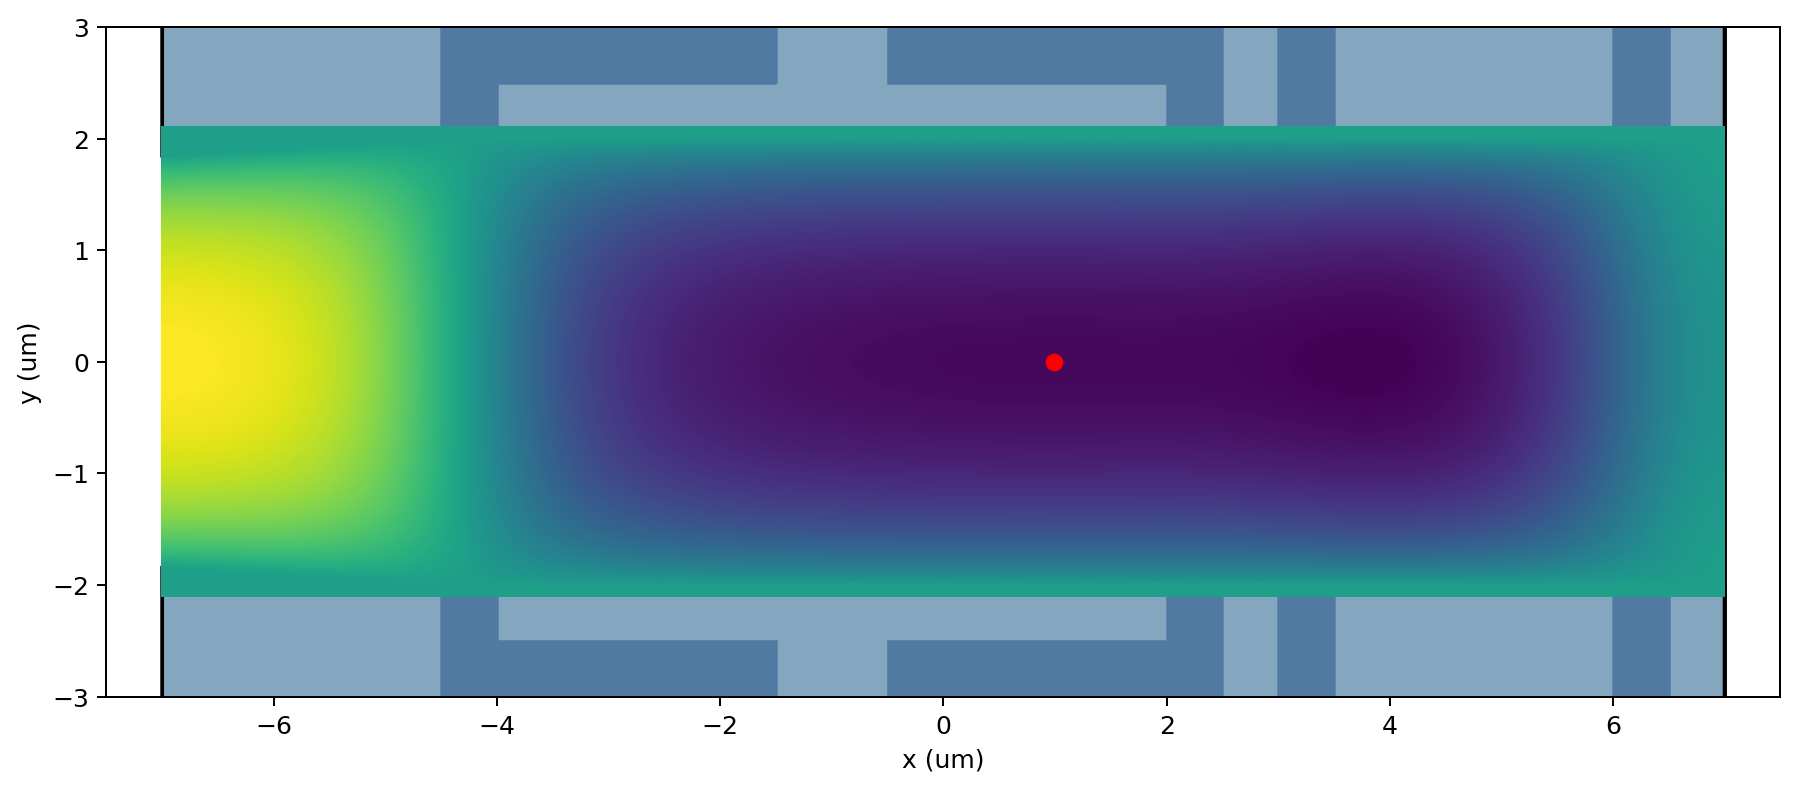

-0.1


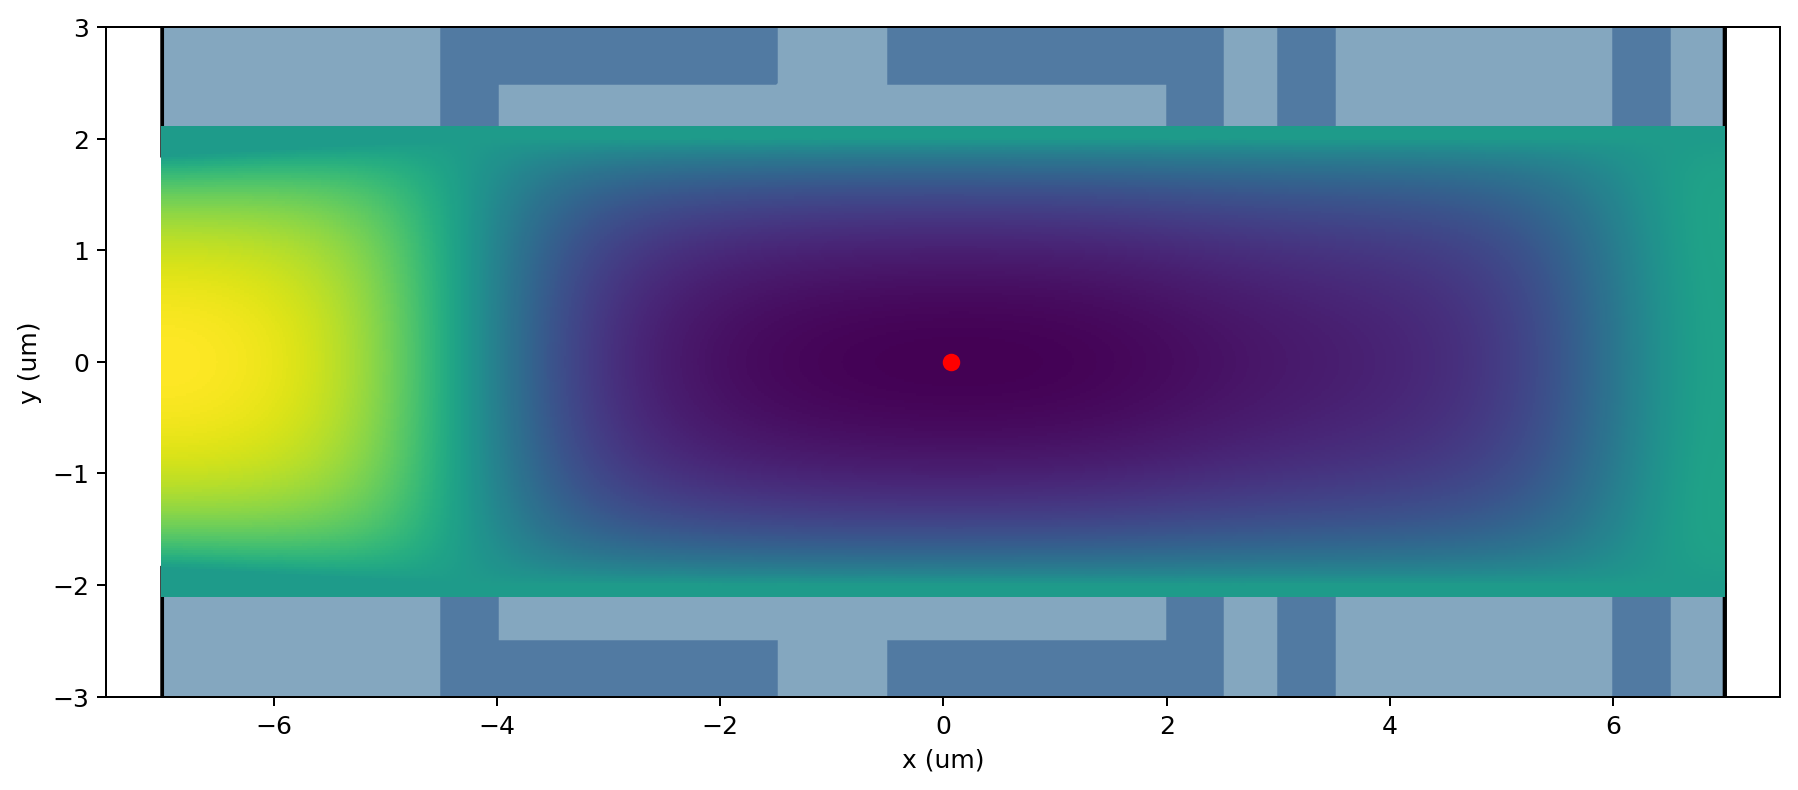

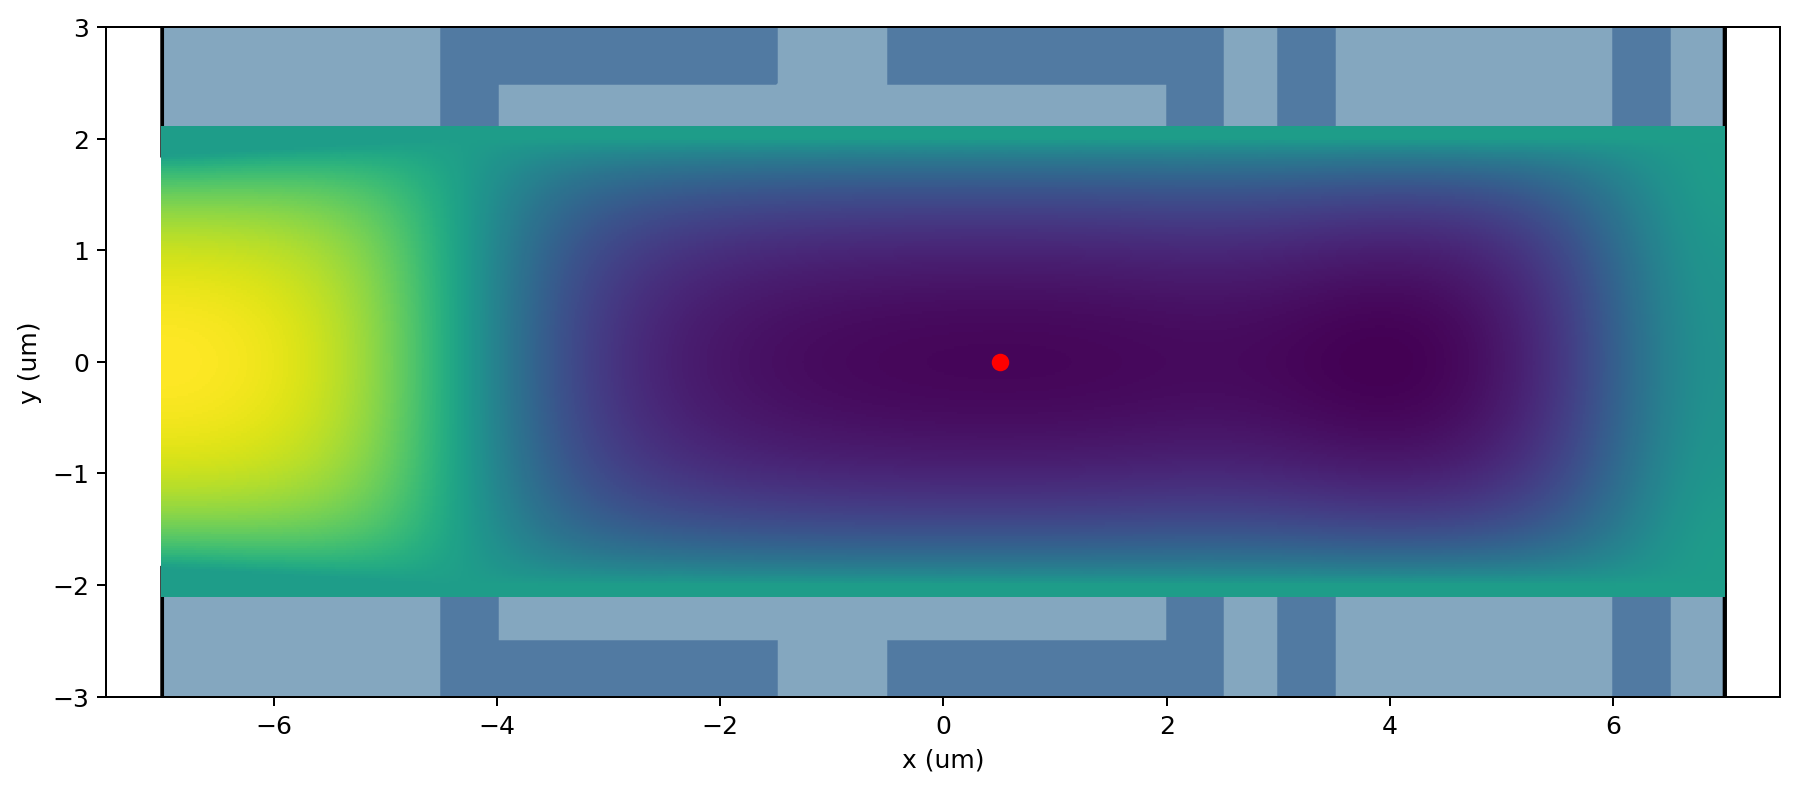

-0.2


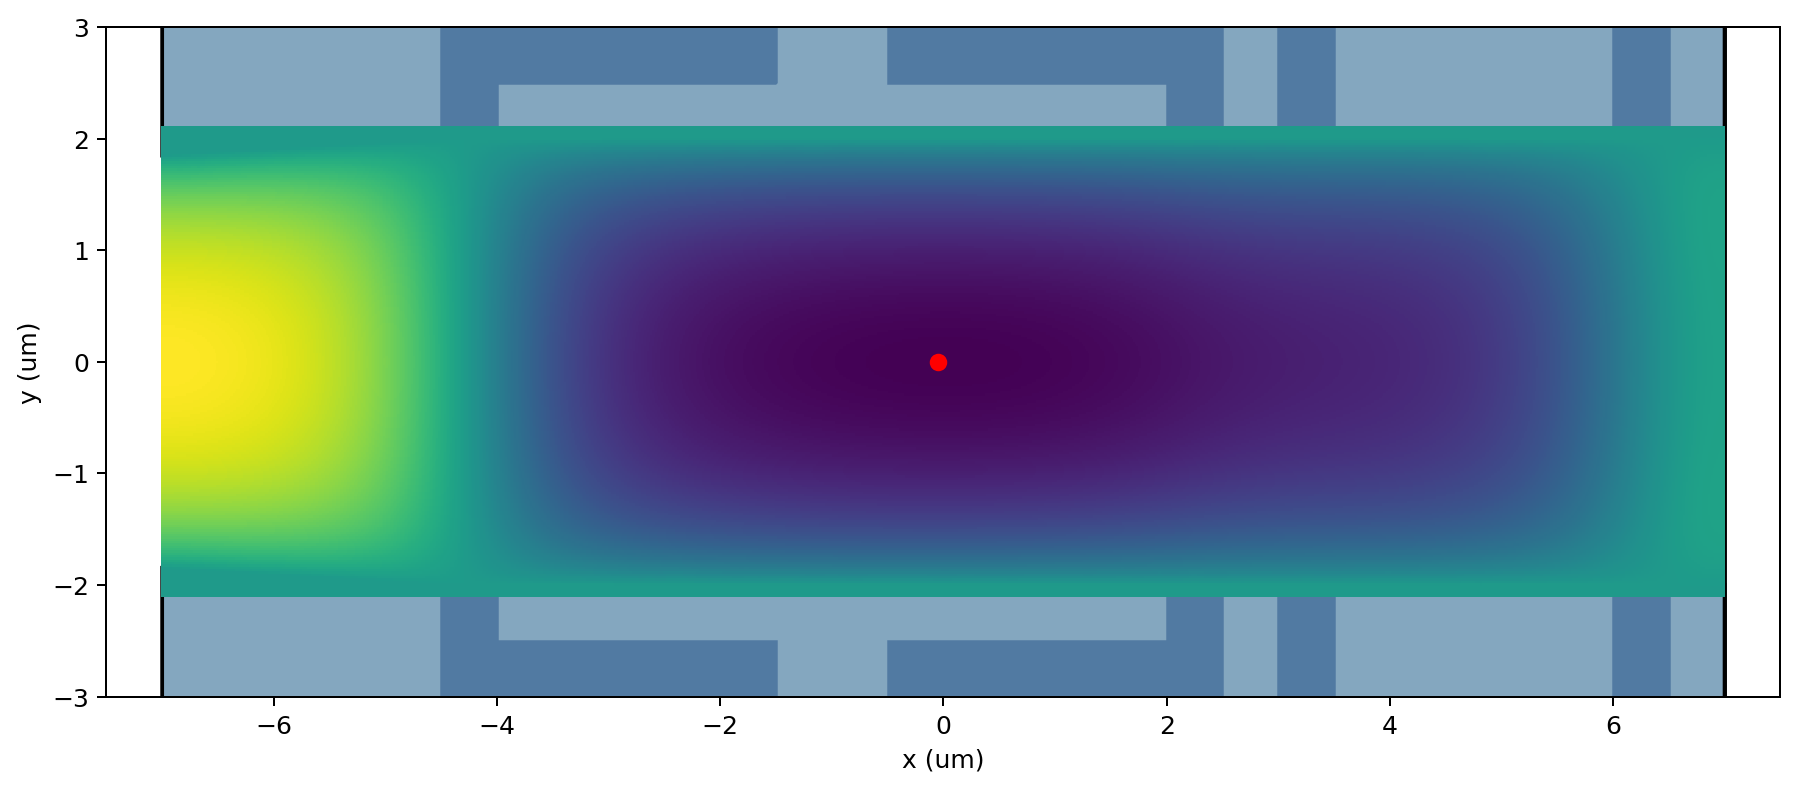

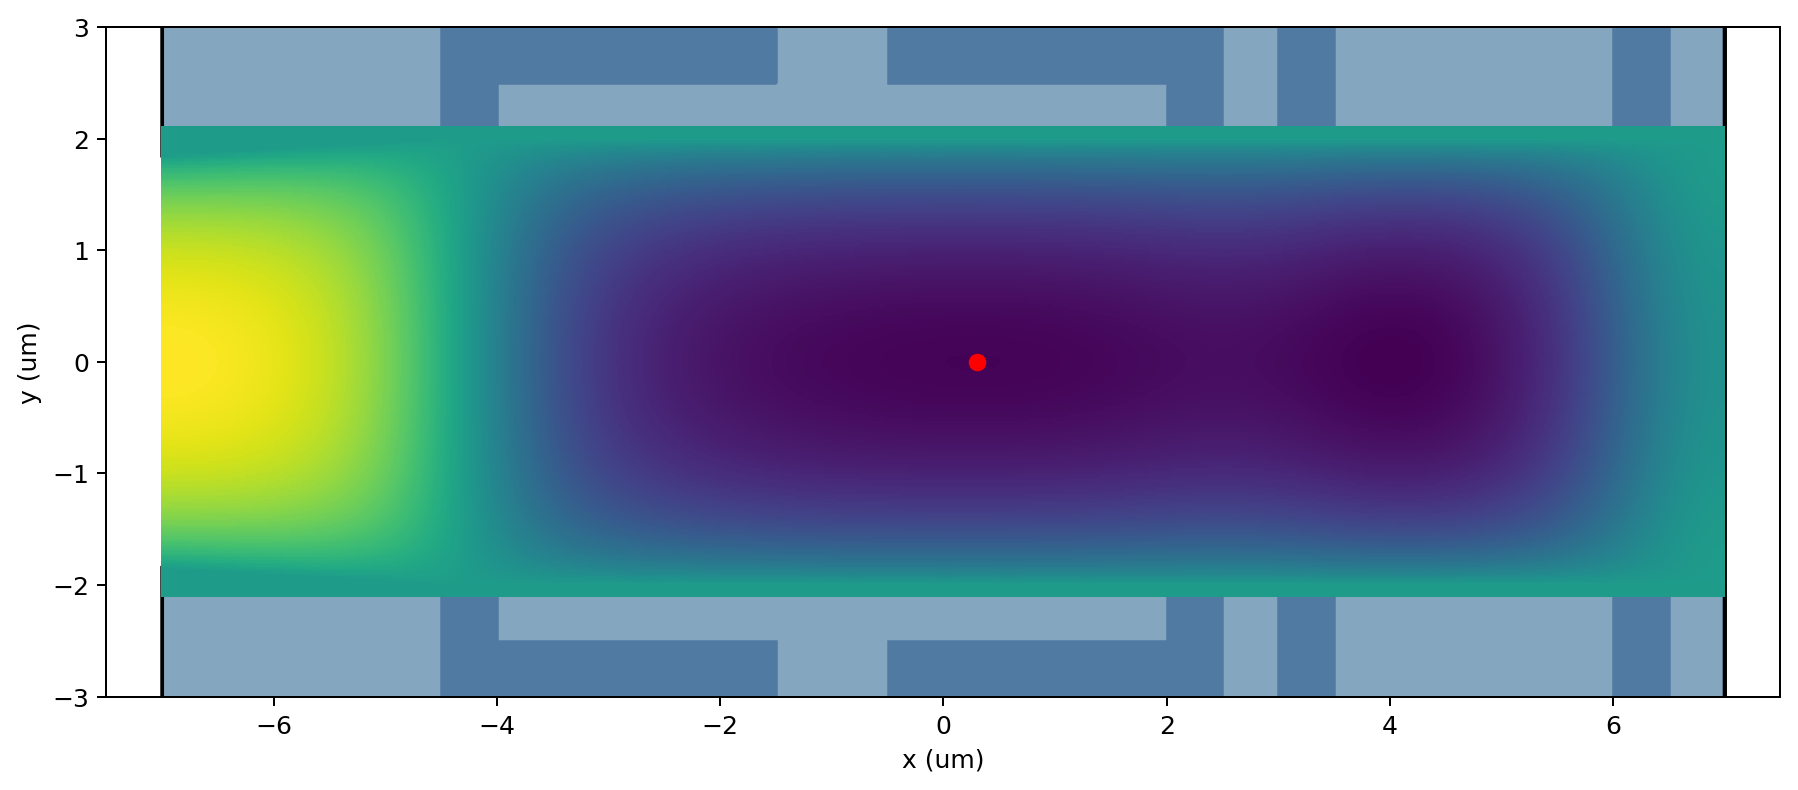

-0.3


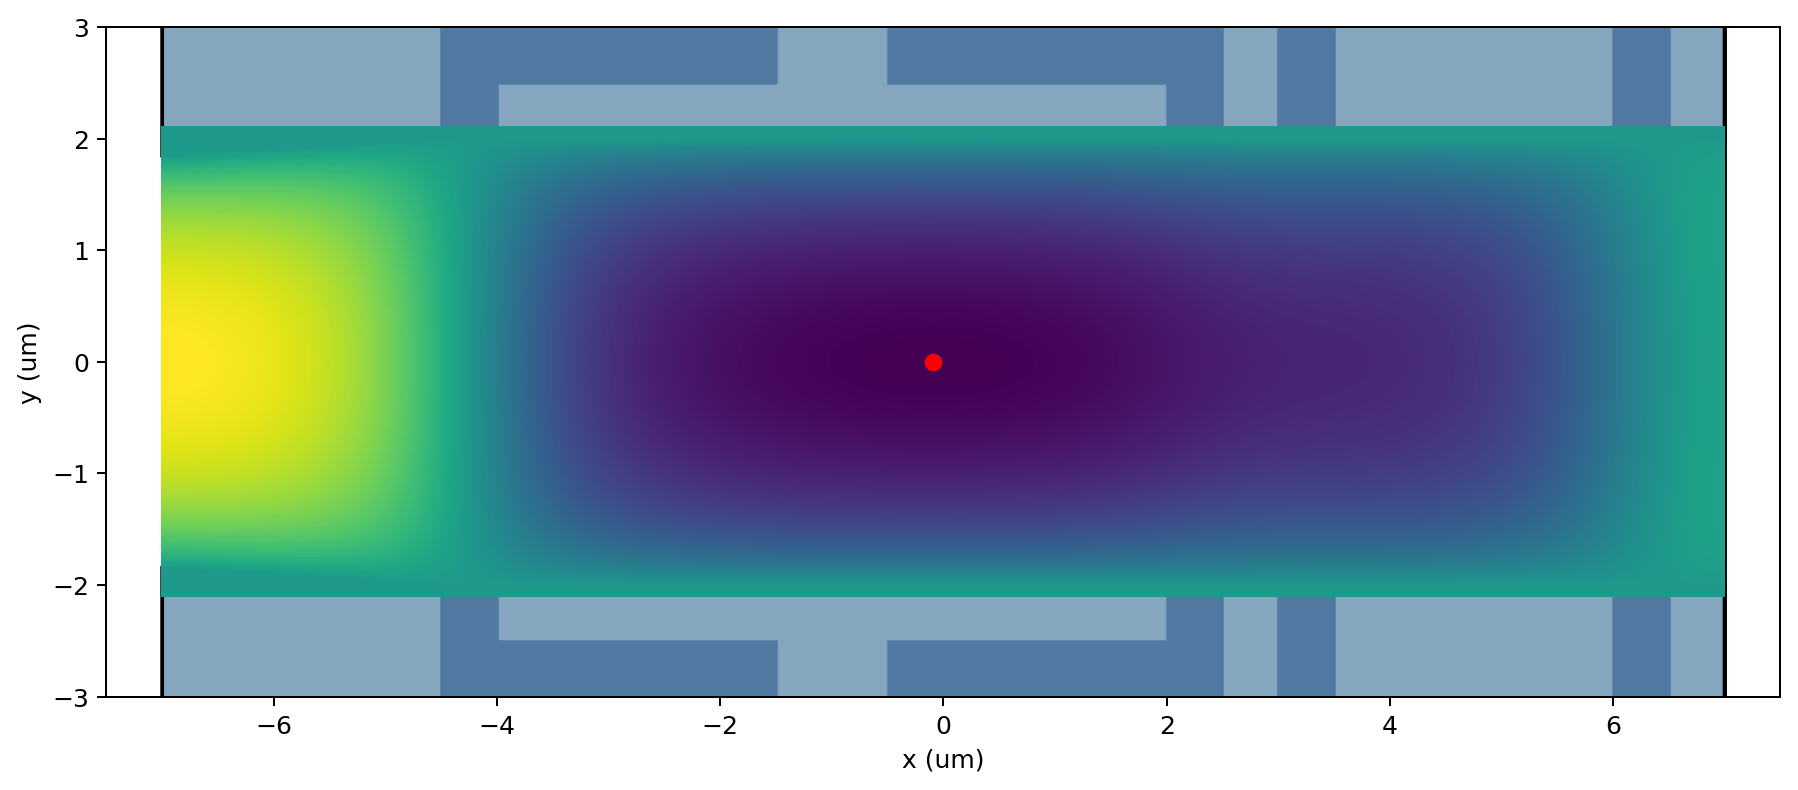

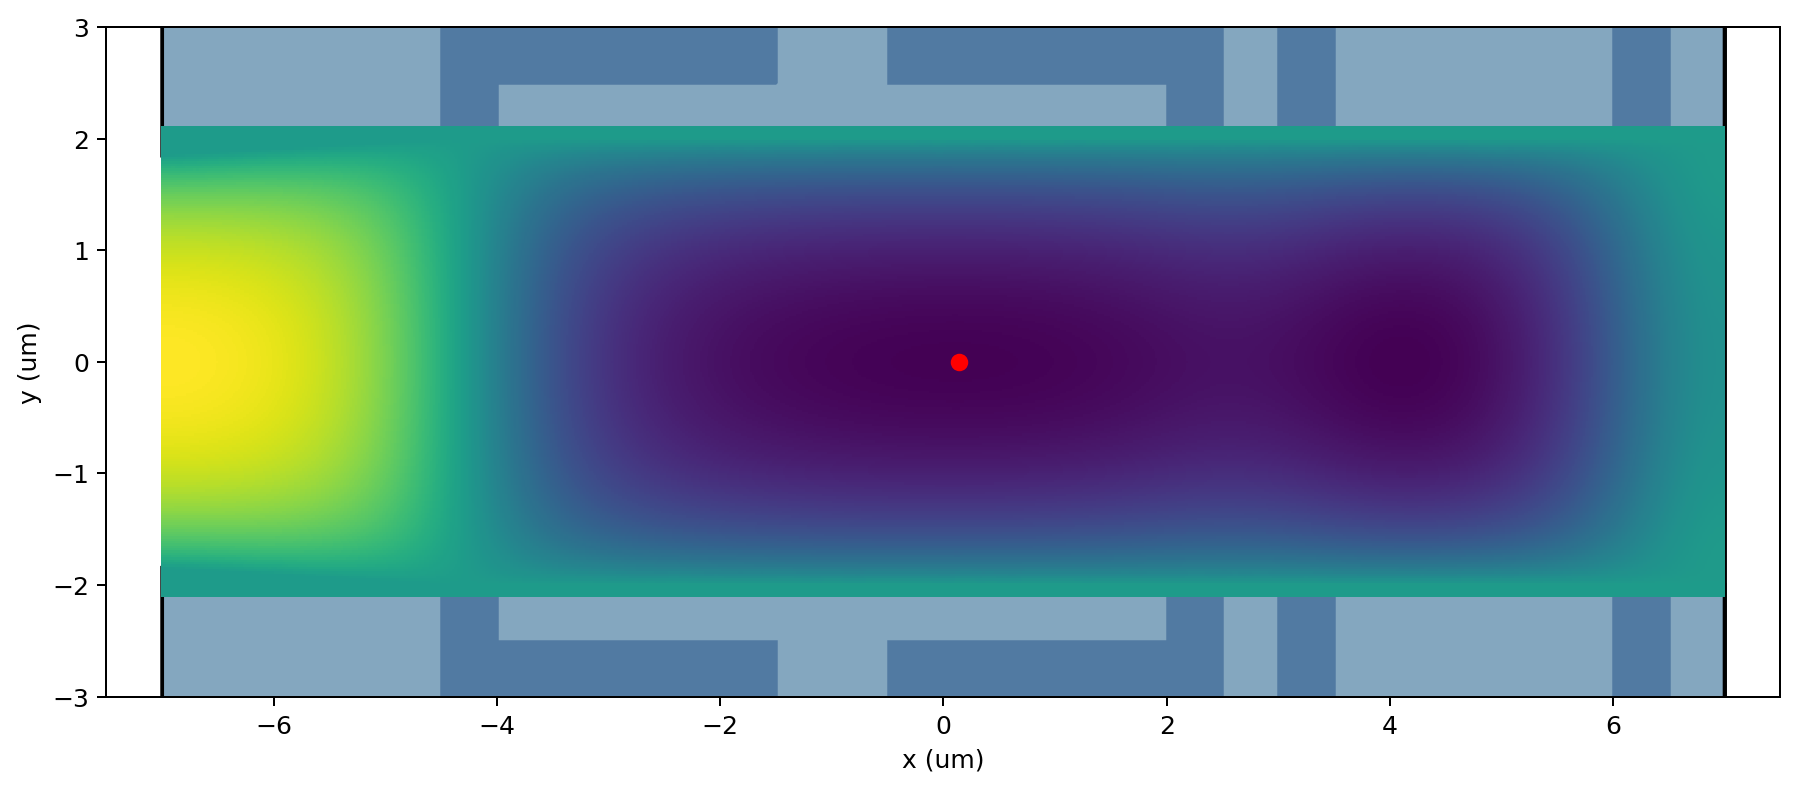

-0.4


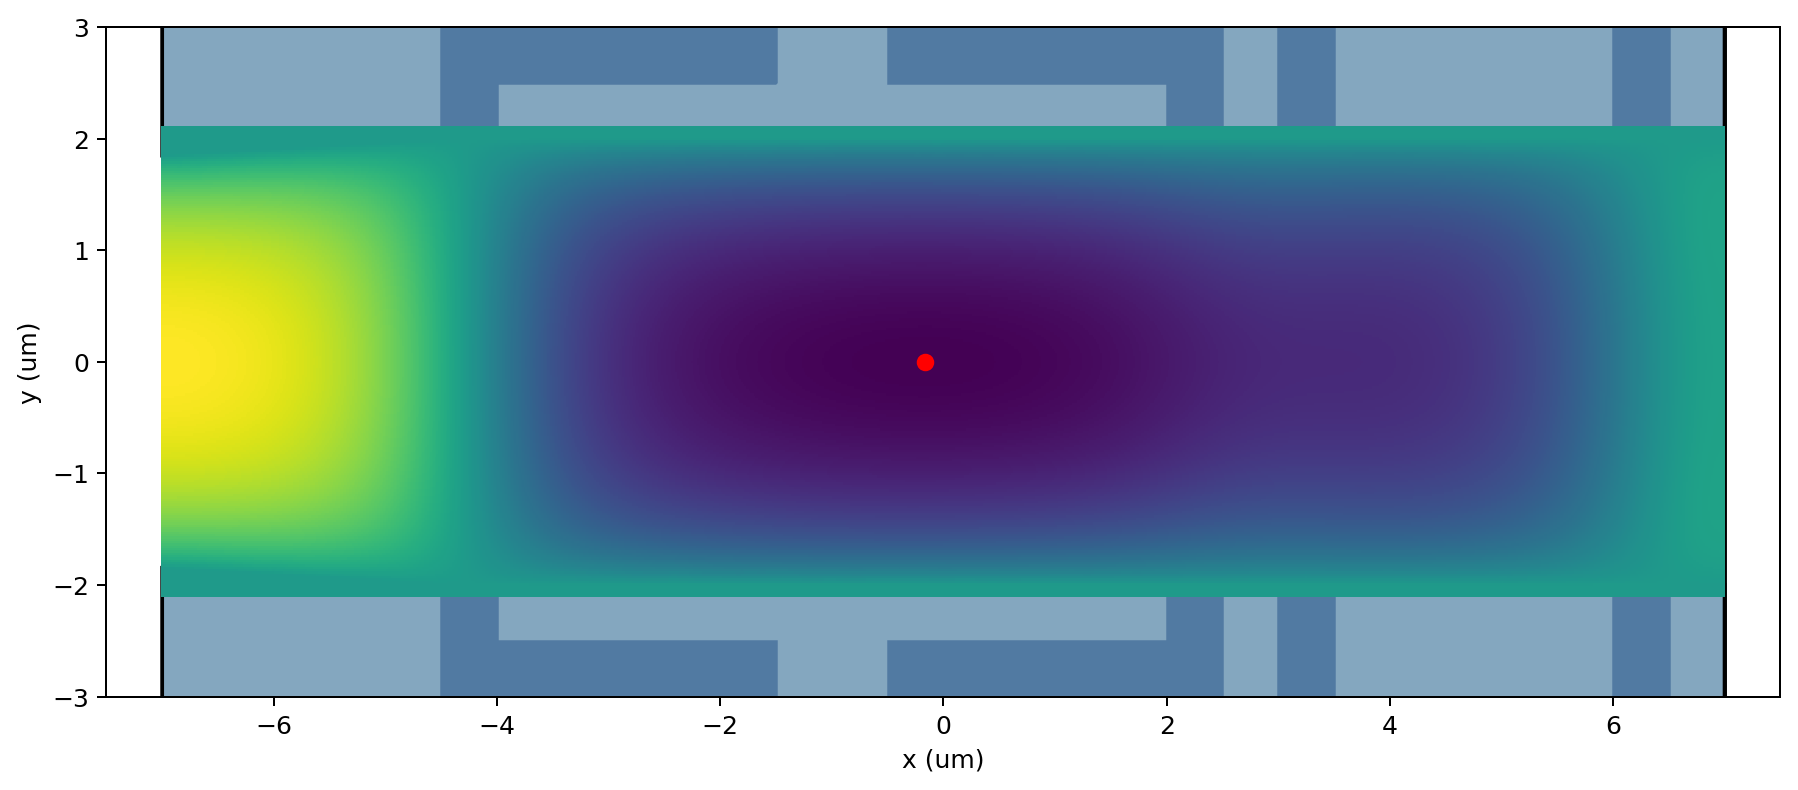

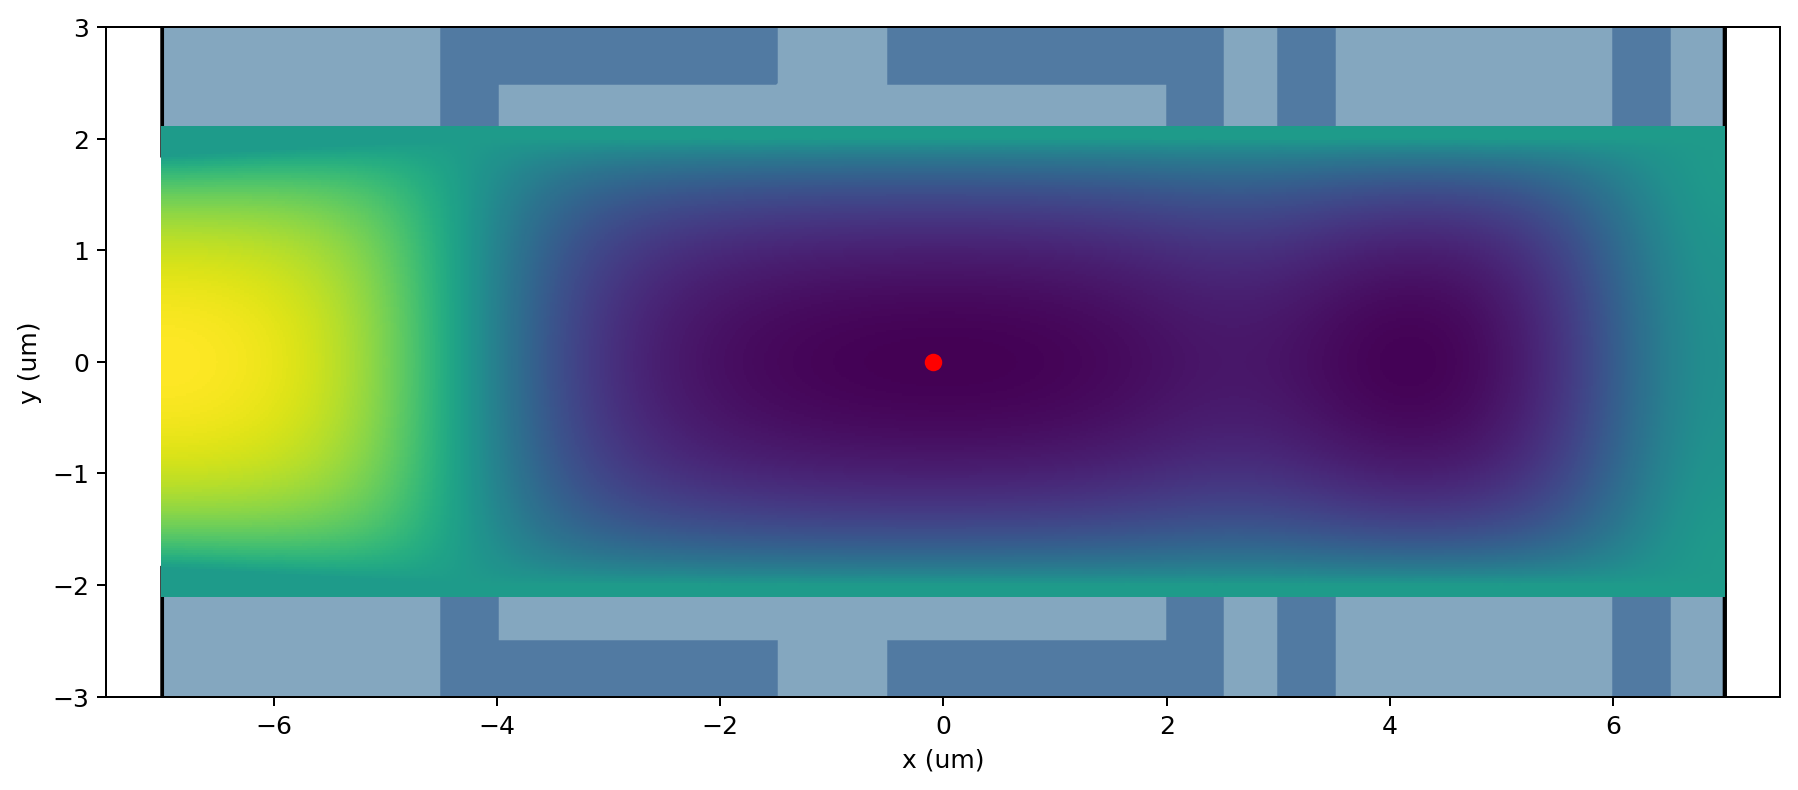

-0.5


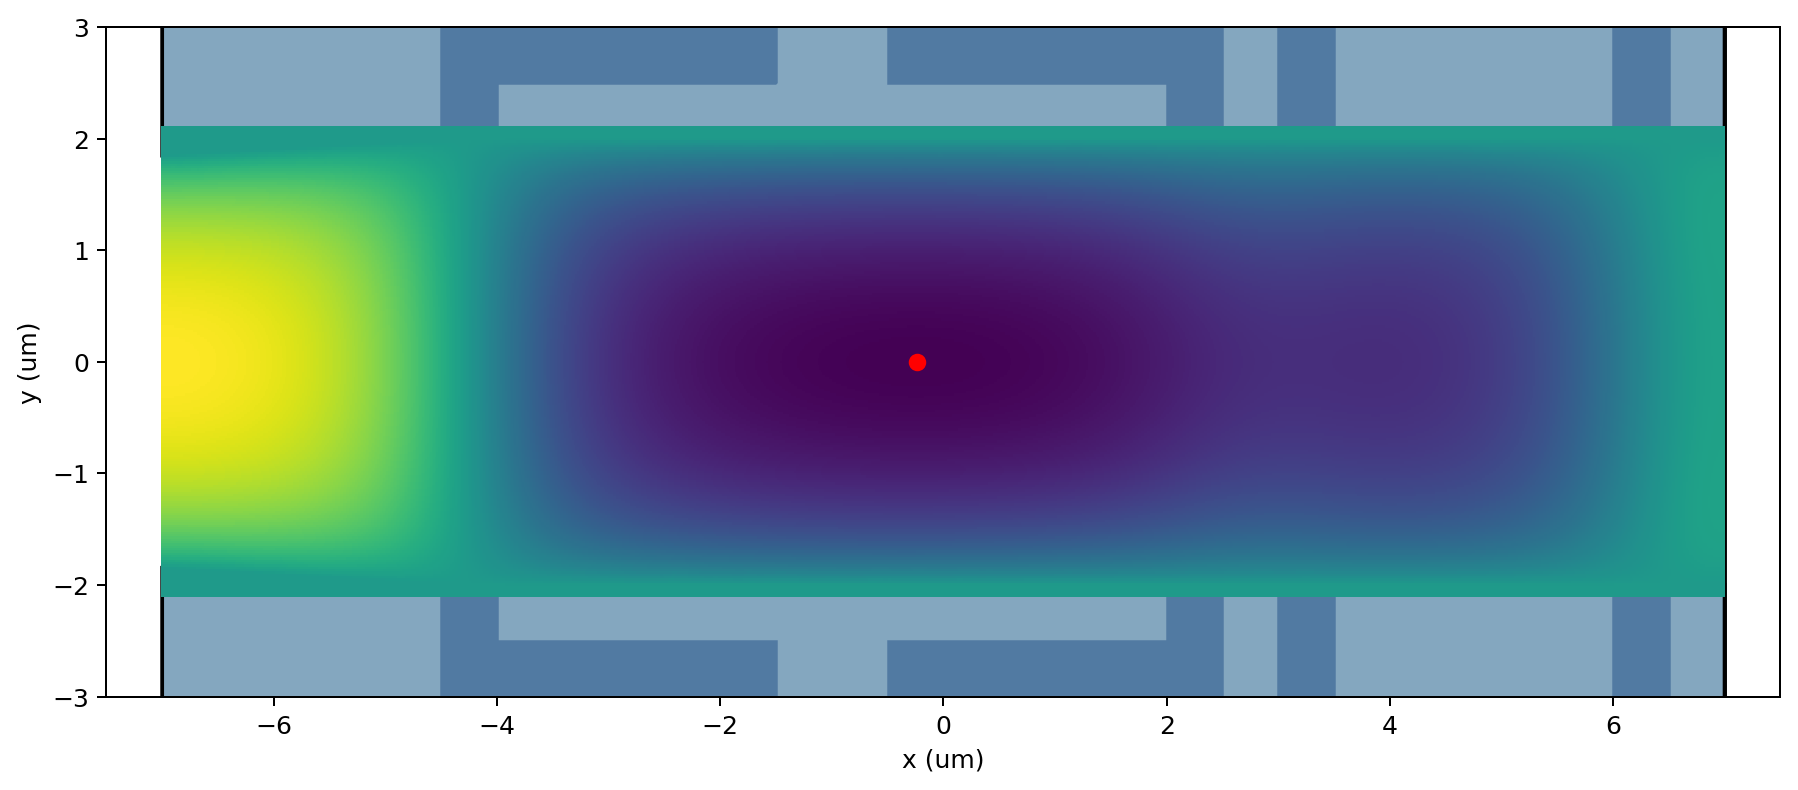

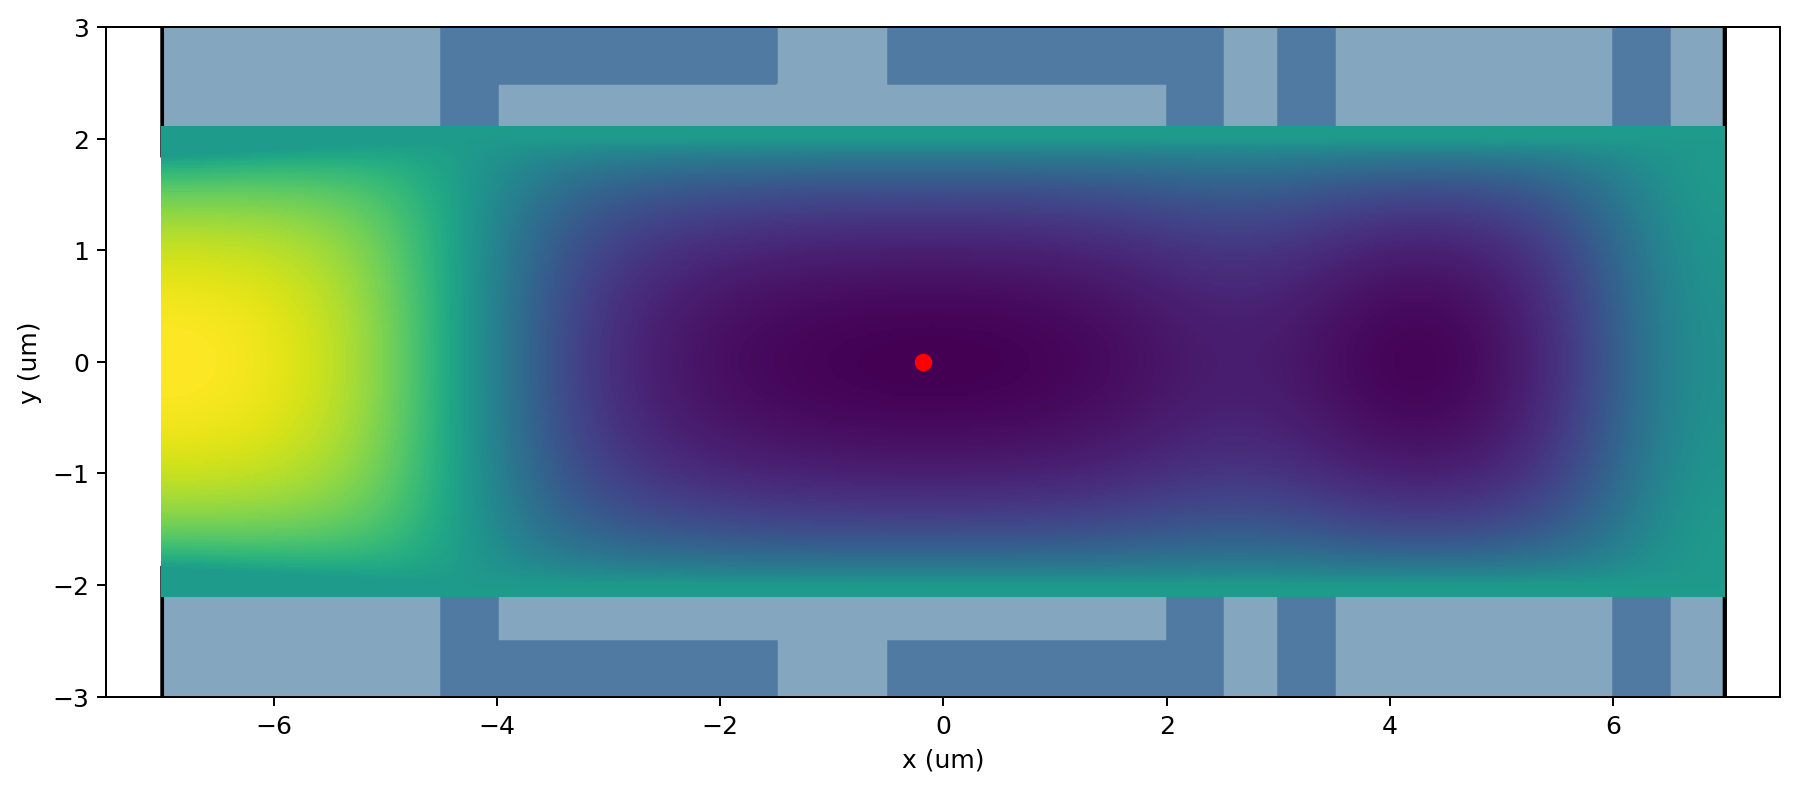

-0.6


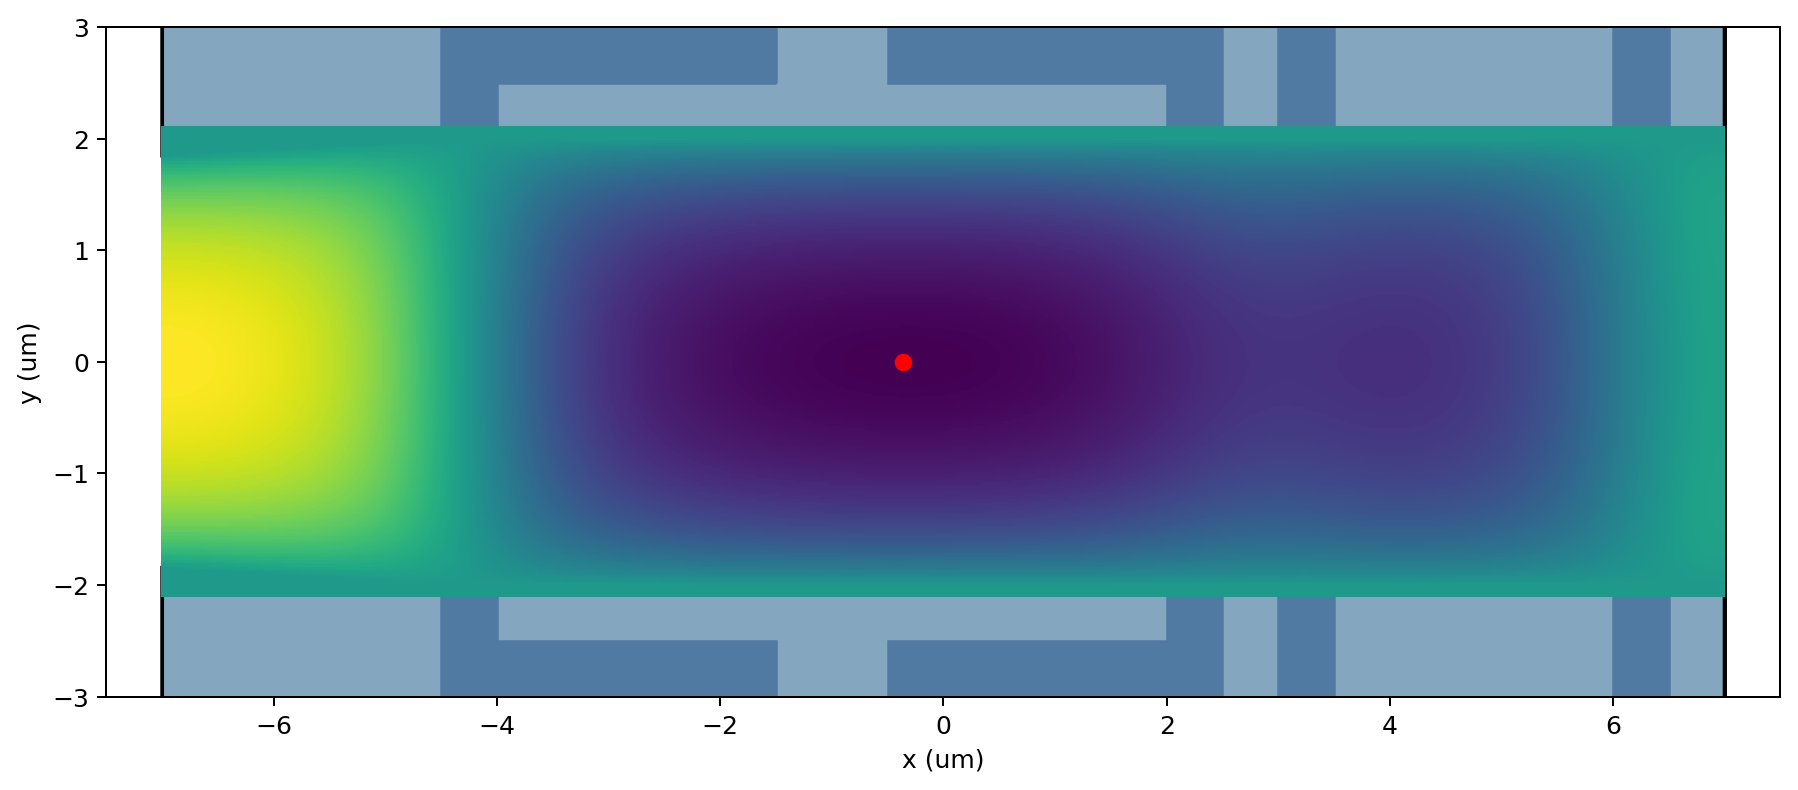

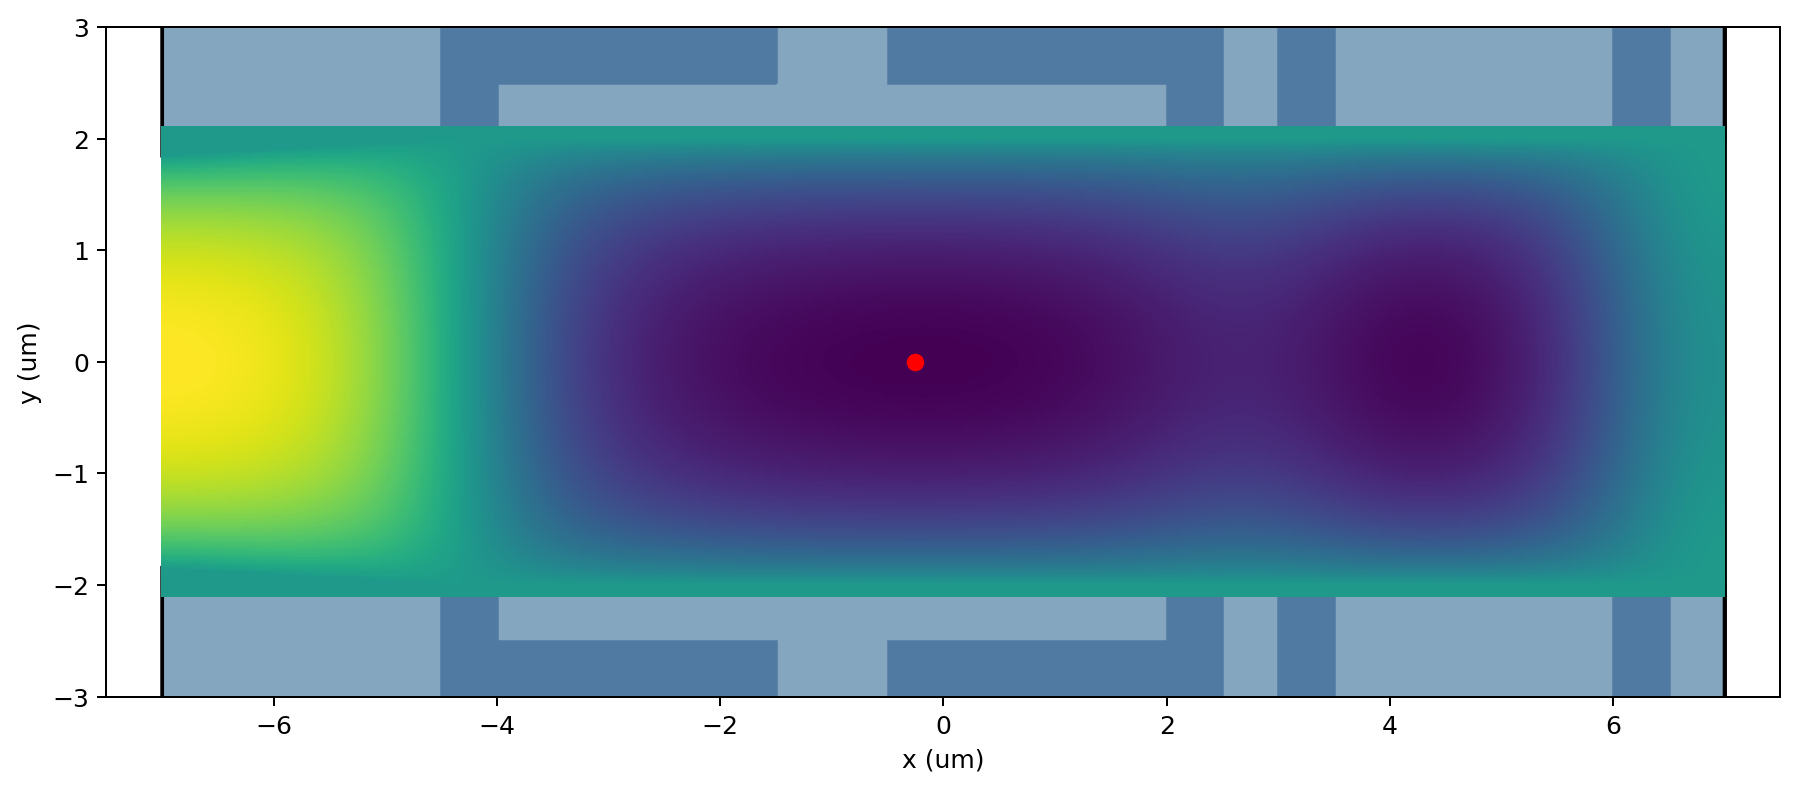

In [11]:
voltages = {
    'Door1':-2,
    'Door2':-2,
    # 'Extra':0,
    'Guard':0,
    'Sense':0,
    'Top':-1,
    'Twiddle':0,
}

N = 1
min_spacing = 0.2
x0,y0 = 0,0
vpp = 0.3

coords = generate_coords_deterministic(int(N),x0,y0,min_spacing).flatten()*1e-6
coords0 = get_min_energy_forcemethod(fm,N,n_timesteps = 2000,init_coords=coords)

for guard in [0,-.1,-.2,-.3,-.4,-.5,-.6]:
    coords = coords0
    voltages['Guard'] = guard
    print(guard)
    for twiddle in [-vpp/2,vpp/2]:
        voltages['Twiddle'] = twiddle
        x,y,z = ph.potential(p,voltages)
        fm = FullModel(ph.phi, voltages, **options)
        coords = get_min_energy_forcemethod(fm,N,n_timesteps = 2000,init_coords=coords)
        
        device.quickplot(plot_config)
        plt.pcolormesh(x,y,-z.T)
        plt.xlim(-7.5,7.5)
        plt.ylim(-3,3)
        for xi,yi in zip(coords[0::2],coords[1::2]):
            plt.plot(xi*1e6,yi*1e6,'ro')
        plt.ylabel("y (um)")
        plt.xlabel("x (um)")
        plt.show()

In [12]:
voltages = {
    'Door1':-2,
    'Door2':-2,
    # 'Extra':0,
    'Guard':0,
    'Sense':0,
    'Top':-1,
    'Twiddle':0,
}
drive  = 'Twiddle'
drive2 = 'Door1'
sweep = 'Guard'
vpp = 0.3
vpp2 = vpp*0.0113 # coupling experimentally obtained from compensating tone
npoints = 41
xs = np.linspace(-.6,.4,npoints)
showPlot = False
Ns = [1]

# for vpp in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
vpps = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
output = pd.DataFrame({sweep:[],'de':[],'N':[]})
for vpp in vpps:
    vpp2 = vpp*0.0113
    for N in Ns:
        # print(vpp,' Vpp, + ',vpp2,' Vpp')
        print(f'---For n = {N} at twiddle {vpp*1e3:.0f} mV and compensation {vpp2*1e3:.0f} mV---')
        coords0 = generate_coords_deterministic(N,0, 0,0.1).flatten()*1e-6
        for i in range(len(xs)):
            if i%5==0:
                print(round(i/npoints*100,1),'%',end=', ')
            voltagei = voltages.copy()
            voltagei[sweep] = xs[i] 
            voltagei[drive2] -= -vpp2/2
            voltagei[drive]  += vpp/2
            fm = FullModel(ph.phi, voltagei, **options)
            coords1 = get_min_energy_forcemethod(fm,N,n_timesteps = 10000,init_coords=coords0)
            # if showPlot:
            #     x,y,z = ph.potential(ph.phi,voltagei)
            #     device.quickplot(plot_config)
            #     plt.pcolormesh(x,y,z.T,alpha = 0.8)
            #     plt.colorbar()
            #     plt.xlim(-7.5,5.5)
            #     plt.ylim(-3,3)
            #     for x,y in zip(coords1[0::2],coords1[1::2]):
            #         plt.plot(x*1e6,y*1e6,'ro')
            #     plt.title(f'{sweep2}={x2s[i]},{sweep}={x1s[j]}')
            #     plt.show()
                
            voltagei[drive2] += vpp2
            voltagei[drive]  -= vpp
            fm = FullModel(ph.phi, voltagei, **options)
            coords = get_min_energy_forcemethod(fm,N,n_timesteps = 10000,init_coords=coords1,returnAll=False)  
            de = 0 
            for ni in range(N):
                x0,y0 = np.argmin(abs(1e6*coords1[2*ni]-ph.phi['xlist'])),np.argmin(abs(1e6*coords1[2*ni+1]-ph.phi['ylist']))
                xf,yf = np.argmin(abs(1e6*coords[2*ni]-ph.phi['xlist'])),np.argmin(abs(1e6*coords[2*ni+1]-ph.phi['ylist']))
                de += ph.phi['Sense'][xf,yf]-ph.phi['Sense'][x0,y0]
            output.loc[len(output)] = [xs[i],de,N]
            # print()

# gain = (1.602e-19*23.8*0.88)/(3.3e-12*2*np.sqrt(2)) # Convert extracted induced charge to measured Vrms
# print('max =',round(max(output.de*gain*1e6),3),'Vrms (alpha max =',round(max(output.de),3),'), min =',round(min(output.de*gain*1e6),3),'Vrms(alpha min =',round(min(output.de),3),')')
# plt.figure(figsize=(10,5))
# plt.title('Y Cut at $V_{sense}$ = %.1f' %voltages['Sense'] + 'V, %i' %(vpp*1e3) + ' mVpp + %i'%(vpp2*1e3) + ' mVpp')
# for 
# plt.plot(output.Guard(0:),output.de*gain*1e6,label='%i' %(vpp*1e3) + ' mVpp + %i'%(vpp2*1e3) + ' mVpp')
# plt.xlabel('$V_{guard}$ (V)')
# plt.ylabel('Amplitude ($V_{rms}$)')
# plt.legend()
# plt.show()

# # Plotting results        
# gain = (1.602e-19*24)/(3.3e-12*2*np.sqrt(2))
# for ni,n in enumerate(Ns):
#     df = output.where(output['N']==n).dropna().pivot(columns=sweep2,index=sweep,values='de')
#     plt.pcolormesh(df.columns,df.index,df*gain,alpha = 1)
#     plt.colorbar()
#     plt.xlabel(sweep2)
#     plt.ylabel(sweep)
#     plt.title('%.1f'%vpp+' Vpp')
#     plt.show()

---For n = 1 at twiddle 200 mV and compensation 2 mV---
0.0 %, 12.2 %, 24.4 %, 36.6 %, 48.8 %, 61.0 %, 73.2 %, 85.4 %, 97.6 %, ---For n = 1 at twiddle 300 mV and compensation 3 mV---
0.0 %, 12.2 %, 24.4 %, 36.6 %, 48.8 %, 61.0 %, 73.2 %, 85.4 %, 97.6 %, ---For n = 1 at twiddle 400 mV and compensation 5 mV---
0.0 %, 12.2 %, 24.4 %, 36.6 %, 48.8 %, 61.0 %, 73.2 %, 85.4 %, 97.6 %, ---For n = 1 at twiddle 500 mV and compensation 6 mV---
0.0 %, 12.2 %, 24.4 %, 36.6 %, 48.8 %, 61.0 %, 73.2 %, 85.4 %, 97.6 %, ---For n = 1 at twiddle 600 mV and compensation 7 mV---
0.0 %, 12.2 %, 24.4 %, 36.6 %, 48.8 %, 61.0 %, 73.2 %, 85.4 %, 97.6 %, ---For n = 1 at twiddle 700 mV and compensation 8 mV---
0.0 %, 12.2 %, 24.4 %, 36.6 %, 48.8 %, 61.0 %, 73.2 %, 85.4 %, 97.6 %, ---For n = 1 at twiddle 800 mV and compensation 9 mV---
0.0 %, 12.2 %, 24.4 %, 36.6 %, 48.8 %, 61.0 %, 73.2 %, 85.4 %, 97.6 %, ---For n = 1 at twiddle 900 mV and compensation 10 mV---
0.0 %, 12.2 %, 24.4 %, 36.6 %, 48.8 %, 61.0 %, 73.2 %,

In [14]:
max(output.de[(npoints*6):(npoints+npoints*6)])-min(output.de[(npoints*6):(npoints+npoints*6)])

0.46960189662000007

max = 0.172 Vrms (alpha max = 0.479 ), min = 0.0 Vrms(alpha min = 0.0 )


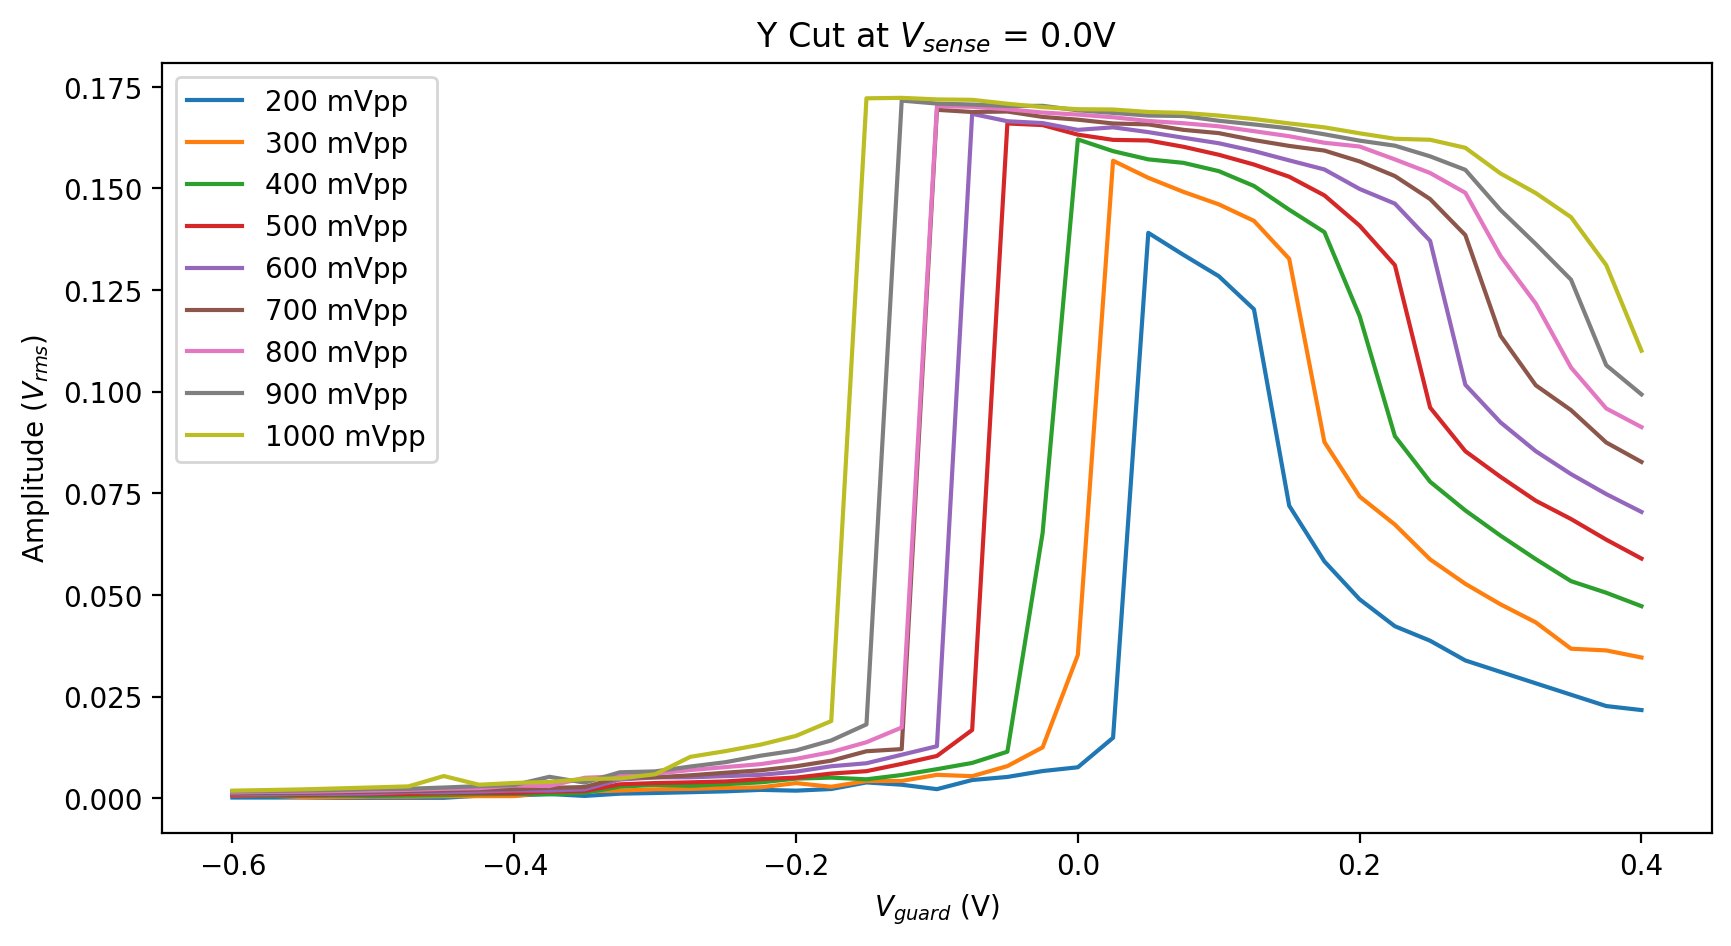

In [15]:
gain = (1.602e-19*23.8*0.88)/(3.3e-12*2*np.sqrt(2)) # Convert extracted induced charge to measured Vrms
print('max =',round(max(output.de*gain*1e6),3),'Vrms (alpha max =',round(max(output.de),3),'), min =',round(min(output.de*gain*1e6),3),'Vrms(alpha min =',round(min(output.de),3),')')
plt.figure(figsize=(10,5))
plt.title('Y Cut at $V_{sense}$ = %.1f' %voltages['Sense'] + 'V') # , %i' %(vpp*1e3) + ' mVpp + %i'%(vpp2*1e3) + ' mVpp

# plt.plot(output.Guard(0:40),output.de(0:40)*gain*1e6,label='%i' %(vpp*1e3) + ' mVpp + %i'%(vpp2*1e3) + ' mVpp')
x = output.Guard
y = output.de
for i in np.arange(0,np.size(vpps)):
    index1 = npoints*i
    index2 = npoints+npoints*i
    plt.plot(x[index1:index2],y[index1:index2]*gain*1e6,label='%i' %(vpps[i]*1e3) + ' mVpp')
plt.xlabel('$V_{guard}$ (V)')
plt.ylabel('Amplitude ($V_{rms}$)')
plt.legend()
plt.show()

In [ ]:
voltages = {
    'Door1':-2,
    'Door2':-2,
    # 'Extra':0,
    'Guard':0,
    'Sense':0,
    'Top':-1,
    'Twiddle':0,
}
drive  = 'Twiddle'
drive2 = 'Door1'
sweep2 = 'Sense'
sweep = 'Guard'
vpp = 0.8
vpp2 = vpp*0.0113 # coupling experimentally obtained from compensating tone
x1s = np.linspace(-.5,.5,41)
x2s = np.linspace(-.5,.5,41)
showPlot = False
Ns = [4]

for vpp in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]:
    vpp2 = vpp*0.0113
    print(vpp,' Vpp, + ',vpp2,' Vpp')
    output = pd.DataFrame({sweep:[],sweep2:[],'de':[],'N':[]})
    for N in Ns:
        print(f'---{N}---')
        coords0 = generate_coords_deterministic(N,0, 0,0.1).flatten()*1e-6
        for j in range(len(x1s)):
            print(j,end=': ')
            for i in range(len(x2s)):
                if i%5==0:
                    print(i,end=', ')
                voltagei = voltages.copy()
                voltagei[sweep2] = x2s[i] 
                voltagei[sweep] = x1s[j] 
                voltagei[drive2] -= -vpp2/2
                voltagei[drive]  += vpp/2
                fm = FullModel(ph.phi, voltagei, **options)
                coords1 = get_min_energy_forcemethod(fm,N,n_timesteps = 10000,init_coords=coords0)
                if showPlot:
                    x,y,z = ph.potential(ph.phi,voltagei)
                    device.quickplot(plot_config)
                    plt.pcolormesh(x,y,z.T,alpha = 0.8)
                    plt.colorbar()
                    plt.xlim(-7.5,5.5)
                    plt.ylim(-3,3)
                    for x,y in zip(coords1[0::2],coords1[1::2]):
                        plt.plot(x*1e6,y*1e6,'ro')
                    plt.title(f'{sweep2}={x2s[i]},{sweep}={x1s[j]}')
                    plt.show()
                    
                voltagei[drive2] += vpp2
                voltagei[drive]  -= vpp
                fm = FullModel(ph.phi, voltagei, **options)
                coords = get_min_energy_forcemethod(fm,N,n_timesteps = 10000,init_coords=coords1,returnAll=False)  
                de = 0 
                for ni in range(N):
                    x0,y0 = np.argmin(abs(1e6*coords1[2*ni]-ph.phi['xlist'])),np.argmin(abs(1e6*coords1[2*ni+1]-ph.phi['ylist']))
                    xf,yf = np.argmin(abs(1e6*coords[2*ni]-ph.phi['xlist'])),np.argmin(abs(1e6*coords[2*ni+1]-ph.phi['ylist']))
                    de += ph.phi['Sense'][xf,yf]-ph.phi['Sense'][x0,y0]
                output.loc[len(output)] = [x1s[j],x2s[i],de,N]
            print()

    # Plotting results        
    gain = (1.602e-19*24)/(3.3e-12*2*np.sqrt(2))
    for ni,n in enumerate(Ns):
        df = output.where(output['N']==n).dropna().pivot(columns=sweep2,index=sweep,values='de')
        plt.pcolormesh(df.columns,df.index,df*gain,alpha = 1)
        plt.colorbar()
        plt.xlabel(sweep2)
        plt.ylabel(sweep)
        plt.title('%.1f'%vpp+' Vpp')
        plt.show()

In [ ]:
# gain = .160*24/3.3/2/np.sqrt(2)
gain = 1 #(1.602e-19*24)/(3.3e-12*2*np.sqrt(2))
for ni,n in enumerate(Ns):
    df = output.where(output['N']==n).dropna().pivot(columns=sweep2,index=sweep,values='de')
    plt.pcolormesh(df.columns,df.index,df*gain,alpha = 1)
    plt.colorbar()
    plt.xlabel(sweep2)
    plt.ylabel(sweep)
    plt.title('%.1f'%vpp+' Vpp')
    plt.show()